In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortex"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 147s 16ms/step - loss: 0.6736 - acc: 0.7981 - val_loss: 4.6765 - val_acc: 0.4854
Epoch 2/100
9112/9112 [==============================] - 133s 15ms/step - loss: 0.3387 - acc: 0.8995 - val_loss: 1.1779 - val_acc: 0.7969
Epoch 3/100
9112/9112 [==============================] - 130s 14ms/step - loss: 0.2276 - acc: 0.9295 - val_loss: 2.8992 - val_acc: 0.5713
Epoch 4/100
9112/9112 [==============================] - 130s 14ms/step - loss: 0.1949 - acc: 0.9385 - val_loss: 0.2603 - val_acc: 0.9307
Epoch 5/100
9112/9112 [==============================] - 130s 14ms/step - loss: 0.1506 - acc: 0.9519 - val_loss: 0.5035 - val_acc: 0.8672
Epoch 6/100
9112/9112 [==============================] - 129s 14ms/step - loss: 0.1128 - acc: 0.9663 - val_loss: 0.2899 - val_acc: 0.9248
Epoch 7/100
9112/9112 [==============================] - 130s 14ms/step - loss: 0.0986 - acc: 0.9685 - val_loss: 0.8397 - va

9114/9114 [==============================] - 128s 14ms/step - loss: 0.0653 - acc: 0.9789 - val_loss: 0.2159 - val_acc: 0.9540
Epoch 17/100
9114/9114 [==============================] - 127s 14ms/step - loss: 0.0638 - acc: 0.9797 - val_loss: 0.2868 - val_acc: 0.9384
Epoch 18/100
9114/9114 [==============================] - 129s 14ms/step - loss: 0.0530 - acc: 0.9832 - val_loss: 0.1609 - val_acc: 0.9628
Epoch 19/100
9114/9114 [==============================] - 128s 14ms/step - loss: 0.0360 - acc: 0.9885 - val_loss: 0.2124 - val_acc: 0.9432
Epoch 20/100
9114/9114 [==============================] - 127s 14ms/step - loss: 0.0476 - acc: 0.9839 - val_loss: 0.2885 - val_acc: 0.9335
Epoch 21/100
9114/9114 [==============================] - 126s 14ms/step - loss: 0.0432 - acc: 0.9862 - val_loss: 0.2386 - val_acc: 0.9491
Epoch 22/100
9114/9114 [==============================] - 127s 14ms/step - loss: 0.0436 - acc: 0.9845 - val_loss: 0.4553 - val_acc: 0.9070
Epoch 23/100
9114/9114 [================

Epoch 75/100
9114/9114 [==============================] - 131s 14ms/step - loss: 0.0090 - acc: 0.9976 - val_loss: 0.2005 - val_acc: 0.9706
Epoch 76/100
9114/9114 [==============================] - 128s 14ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1907 - val_acc: 0.9697
Epoch 77/100
9114/9114 [==============================] - 128s 14ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1737 - val_acc: 0.9706
Epoch 78/100
9114/9114 [==============================] - 127s 14ms/step - loss: 0.0010 - acc: 0.9997 - val_loss: 0.1762 - val_acc: 0.9697
Epoch 79/100
9114/9114 [==============================] - 128s 14ms/step - loss: 8.5309e-04 - acc: 0.9998 - val_loss: 0.1718 - val_acc: 0.9716
Epoch 80/100
9114/9114 [==============================] - 129s 14ms/step - loss: 9.3570e-04 - acc: 0.9998 - val_loss: 0.1777 - val_acc: 0.9726
Epoch 81/100
9114/9114 [==============================] - 141s 15ms/step - loss: 9.3871e-04 - acc: 0.9998 - val_loss: 0.1807 - val_acc: 0.9706
Epoch 82/100
91

In [24]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9299


In [25]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

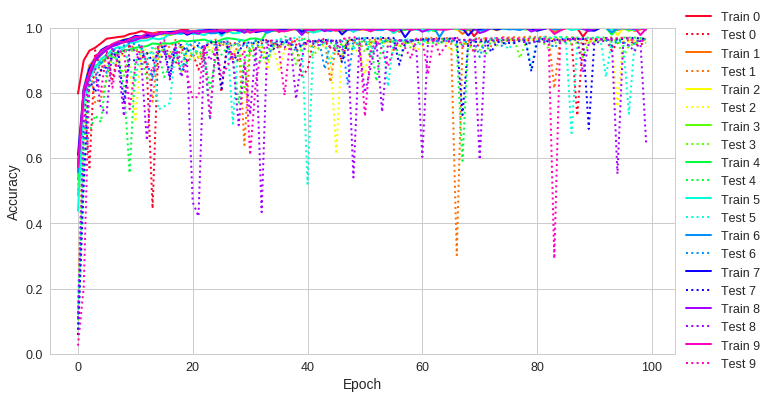

In [26]:
plot_acc(history)

In [27]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

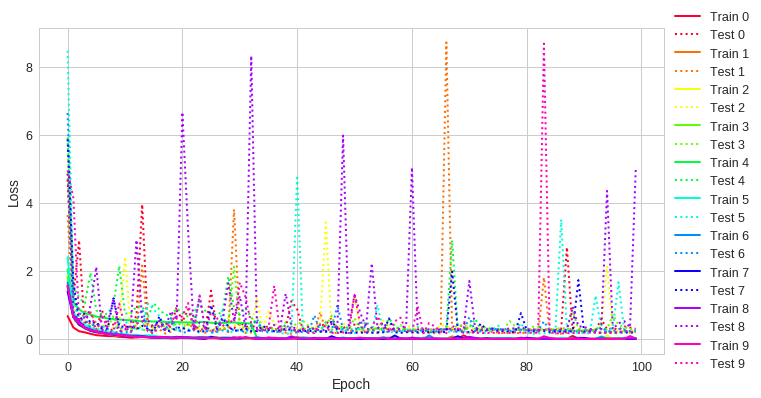

In [28]:
plot_loss(history)

Plotting the confusion matrix


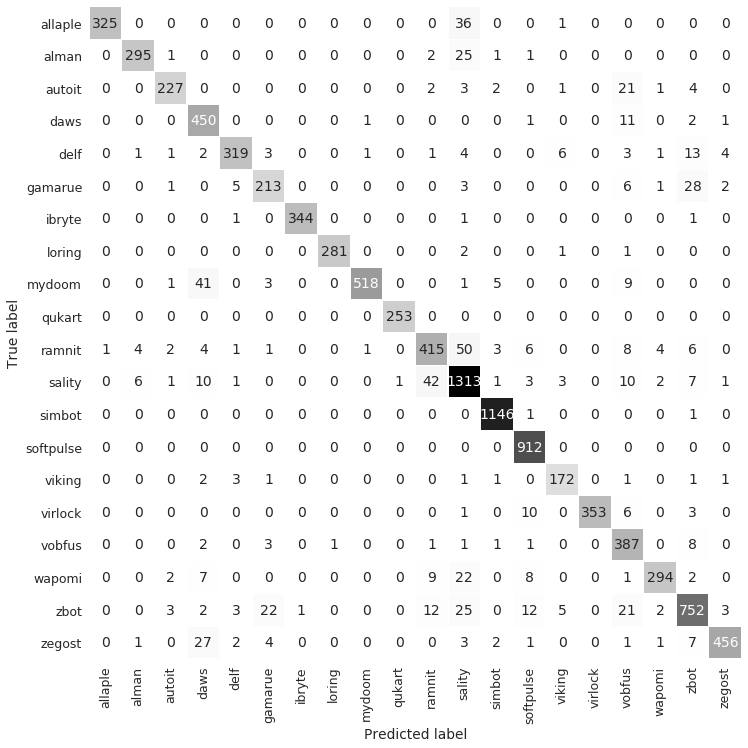

In [30]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


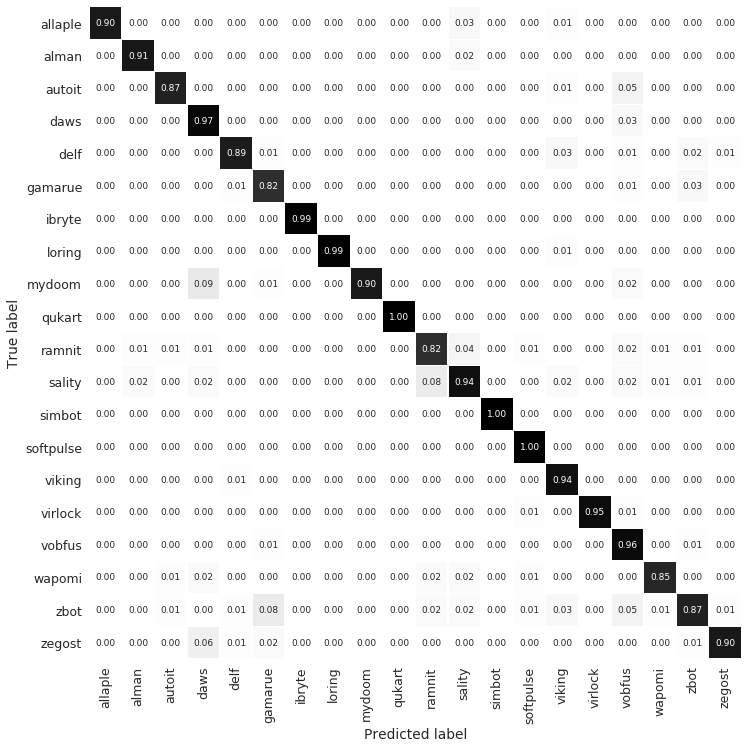

In [32]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
for h in history:
    print(h.history)

{'loss': [0.6736490048526985, 0.3387358157165329, 0.22764416735969267, 0.1949043773814604, 0.15056428180139142, 0.11278789280157428, 0.09862849042490059, 0.08494636750002445, 0.08554407867706848, 0.0627671878458237, 0.05407778554452097, 0.036076321307078836, 0.04671230825229243, 0.05787308247374817, 0.045030024746078035, 0.036854352763454536, 0.04405601134291123, 0.03894790820161611, 0.02219920401911446, 0.02093925239826494, 0.04410499505580324, 0.030706706508020876, 0.044625434279911995, 0.014787197505689688, 0.009037292784932736, 0.05531884442260026, 0.03206276796483286, 0.010738063694004568, 0.012503052237607606, 0.020415966061668917, 0.01830686261571738, 0.04910554726486163, 0.015616754961717846, 0.004075643284406231, 0.0033805223324726253, 0.04381071719349201, 0.017249500731398325, 0.004384383024495209, 0.002822270986185371, 0.023299872074538885, 0.055605684779132136, 0.010682280859385367, 0.004313292517170106, 0.0029090547395246623, 0.001982433872149338, 0.012157253281899922, 0.0

In [34]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

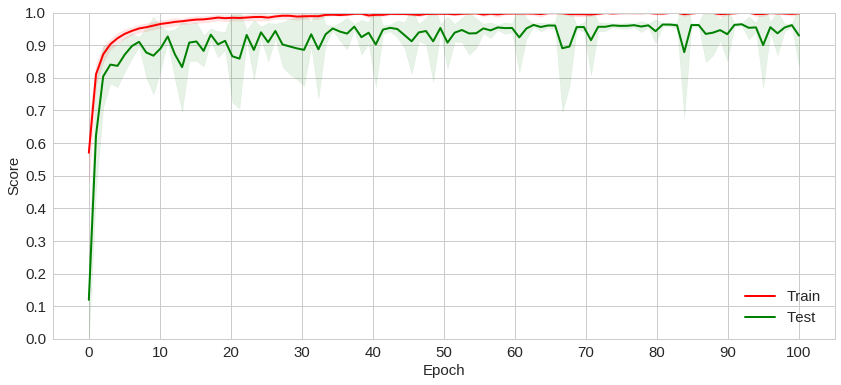

In [35]:
plot_mean_acc(history)

In [36]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

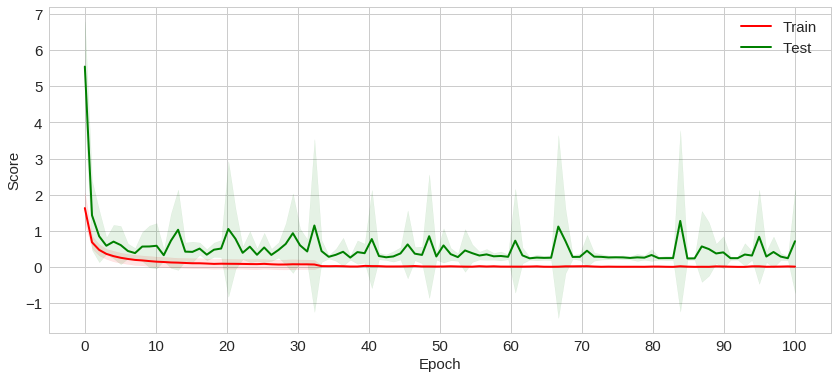

In [37]:
plot_mean_loss(history)

In [38]:
hist = [{'loss': [0.6736490048526985, 0.3387358157165329, 0.22764416735969267, 0.1949043773814604, 0.15056428180139142, 0.11278789280157428, 0.09862849042490059, 0.08494636750002445, 0.08554407867706848, 0.0627671878458237, 0.05407778554452097, 0.036076321307078836, 0.04671230825229243, 0.05787308247374817, 0.045030024746078035, 0.036854352763454536, 0.04405601134291123, 0.03894790820161611, 0.02219920401911446, 0.02093925239826494, 0.04410499505580324, 0.030706706508020876, 0.044625434279911995, 0.014787197505689688, 0.009037292784932736, 0.05531884442260026, 0.03206276796483286, 0.010738063694004568, 0.012503052237607606, 0.020415966061668917, 0.01830686261571738, 0.04910554726486163, 0.015616754961717846, 0.004075643284406231, 0.0033805223324726253, 0.04381071719349201, 0.017249500731398325, 0.004384383024495209, 0.002822270986185371, 0.023299872074538885, 0.055605684779132136, 0.010682280859385367, 0.004313292517170106, 0.0029090547395246623, 0.001982433872149338, 0.012157253281899922, 0.03477156889907551, 0.01192074352057653, 0.006737884297373561, 0.0041238024769355815, 0.025693955289681887, 0.018806342758710442, 0.012145174631954947, 0.006467932281619291, 0.006313378052357855, 0.012403681720202493, 0.001826642453002634, 0.0009138301555413947, 0.0006473558650476026, 0.0006347104879126059, 0.0006719890333277401, 0.0006137213367811483, 0.0007157372537579846, 0.0005941455373147114, 0.0005271650115703509, 0.0006585763763388591, 0.0005480883608755686, 0.0005971760392938576, 0.000621585193384332, 0.10615054516929948, 0.023373870400555413, 0.005510685592369481, 0.0017413125988193607, 0.0008814548964804874, 0.001158841011639537, 0.0009758342703814608, 0.0011175878478695074, 0.0007159520002754389, 0.0006902466113100212, 0.000567045830052349, 0.00056118655967755, 0.0005338699009285899, 0.0005685487305060678, 0.0005618654286328973, 0.0005820515860021781, 0.0005438586514469196, 0.0006094441935683681, 0.00783764700688745, 0.08890485702316776, 0.012385972231304094, 0.004505915604552973, 0.0009167243104565354, 0.0007466162278940379, 0.006651473921932391, 0.019042172587298067, 0.008726904285754384, 0.0025443690005826423, 0.00241577540098543, 0.017964767075896972, 0.016696220724140506], 'acc': [0.7980684811237928, 0.8994732222293321, 0.929543459279376, 0.9385425813162505, 0.9519315188762072, 0.966308165161729, 0.9685030728709394, 0.9713564531336342, 0.9731123793847316, 0.9805750659518958, 0.9832089552238806, 0.9892449517120281, 0.9856233538191396, 0.9824407374890255, 0.986062335381914, 0.9866110624400433, 0.9866110623353819, 0.9883669885864794, 0.9926470589281907, 0.9938542581211589, 0.9858428446005267, 0.9902326602282704, 0.987489025565592, 0.9961589113257243, 0.9982440737489026, 0.9857330992098332, 0.9900131694468832, 0.9971466198419666, 0.9965978928884986, 0.9939640035118525, 0.9937445127304653, 0.9866110623353819, 0.9937445127304653, 0.9991220368744512, 0.9990122914837577, 0.9869402985074627, 0.9948419666374012, 0.9991220368744512, 0.9992317822651449, 0.9930860403863038, 0.9849648814749781, 0.9952809482001755, 0.9987928007023705, 0.9991220368744512, 0.9993415276558385, 0.9959394205443372, 0.9885864793678666, 0.99571992976295, 0.9978050921861282, 0.9985733099209834, 0.9937445127304653, 0.994622475856014, 0.9968173836698858, 0.9982440737489026, 0.9981343283582089, 0.9955004389815628, 0.9996707638279192, 0.9998902546093064, 0.9997805092186128, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9997805092186128, 0.9739903425102803, 0.992756804214223, 0.9982440737489026, 0.9996707638279192, 0.9997805092186128, 0.9997805092186128, 0.9997805092186128, 0.9996707638279192, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9978050922907895, 0.9725636523266022, 0.99571992976295, 0.9982440737489026, 0.9997805092186128, 0.9997805092186128, 0.9981343283582089, 0.9934152766630459, 0.9969271290605795, 0.9992317822651449, 0.9992317822651449, 0.9961589113257243, 0.9956101843722563], 'val_loss': [4.6764503130884805, 1.17786662524742, 2.89921337089989, 0.2602919152668761, 0.5034552217567807, 0.28991537176568727, 0.8396556391949161, 0.37244792511434, 0.4271853769132017, 0.2721205693474964, 0.36715245791330675, 0.34074993502181883, 0.6869870354229315, 3.954069273197092, 0.26898365901904997, 0.4057922536064371, 0.46987039974683853, 0.5016645921891438, 0.3308559184443993, 0.9418322119967422, 0.5027570185283712, 0.8736600848077418, 0.38567460628808314, 0.29056222870525783, 0.27076821102215165, 1.419469492539231, 0.2732207785837537, 0.27480876720601, 0.33786191777248176, 0.3121365237950453, 0.4885107582045962, 0.3703463228988264, 0.33600826504998205, 0.25482048801473534, 0.30414630768409534, 0.3774306438184163, 0.26976084222561436, 0.27898153090317246, 0.3111744921520616, 1.1136158874433884, 0.8749782075253414, 0.26528204411428113, 0.2559174830106814, 0.322740828002384, 0.3988623782909806, 0.42578544524919026, 0.6281695954951521, 0.2935957697796514, 0.31709826747182923, 0.4067527721101234, 0.42360155005110567, 0.27039977755604117, 0.30649162147317277, 0.26695410466707603, 0.30464793012061353, 0.2907288196320632, 0.3000095884667138, 0.27254009619436337, 0.27626337523883704, 0.2746708351528171, 0.27141307392087377, 0.27228350935225265, 0.27198942738247833, 0.27216885027167503, 0.27112534980748215, 0.27674287836903666, 0.2795033267735185, 0.2890891346492026, 0.27082230610064917, 0.48022375858274025, 0.26916037309696916, 0.23946814075605083, 0.2542251579445143, 0.25726526365694014, 0.26512684251750285, 0.25391679257572486, 0.261652044548478, 0.26045817917180214, 0.2765845322038962, 0.2764572100209337, 0.2766128011131448, 0.27489433666085317, 0.2764441858828053, 0.2791426728836872, 0.27829802356134836, 0.2751708871260048, 0.28169281816374614, 2.6957571255698007, 0.23063124214439945, 0.2267314000067837, 0.23401988055434852, 0.26431851990538524, 0.24229918287431396, 0.5932322006344886, 0.2831032974113534, 0.31484726064021773, 0.27554260252404594, 0.36723174247572654, 0.33622029627968386, 0.29952413864705596], 'val_acc': [0.4853515625, 0.796875, 0.5712890625, 0.9306640625, 0.8671875, 0.9248046875, 0.8408203125, 0.921875, 0.9189453125, 0.9453125, 0.9296875, 0.927734375, 0.87109375, 0.4453125, 0.9482421875, 0.9208984375, 0.9072265625, 0.8876953125, 0.943359375, 0.8935546875, 0.921875, 0.87109375, 0.9326171875, 0.9599609375, 0.9560546875, 0.802734375, 0.9482421875, 0.955078125, 0.9453125, 0.9541015625, 0.923828125, 0.9345703125, 0.951171875, 0.96484375, 0.955078125, 0.9423828125, 0.9619140625, 0.958984375, 0.951171875, 0.8525390625, 0.87109375, 0.9619140625, 0.955078125, 0.95703125, 0.9384765625, 0.9287109375, 0.9013671875, 0.958984375, 0.9609375, 0.943359375, 0.9462890625, 0.9541015625, 0.9560546875, 0.96484375, 0.953125, 0.9609375, 0.9609375, 0.9609375, 0.9619140625, 0.962890625, 0.962890625, 0.962890625, 0.9638671875, 0.962890625, 0.96484375, 0.9638671875, 0.962890625, 0.9619140625, 0.9638671875, 0.923828125, 0.955078125, 0.9638671875, 0.962890625, 0.9609375, 0.9599609375, 0.9599609375, 0.962890625, 0.9619140625, 0.9609375, 0.9609375, 0.9619140625, 0.9619140625, 0.9609375, 0.9609375, 0.9609375, 0.9599609375, 0.9619140625, 0.73046875, 0.9501953125, 0.9658203125, 0.962890625, 0.9638671875, 0.96484375, 0.9296875, 0.9521484375, 0.9541015625, 0.962890625, 0.9482421875, 0.9482421875, 0.9541015625]},
{'loss': [1.573118338413293, 0.6385195449122164, 0.41308935152377796, 0.3243820321567754, 0.26546842555989814, 0.22238545399016132, 0.1780638682043079, 0.15223986761910574, 0.14734008408746085, 0.1235578282915476, 0.11357386745324463, 0.10240558281766497, 0.09001044100749275, 0.07606640173764423, 0.06428613850839938, 0.06534748810134168, 0.06378654833610824, 0.05297270778399831, 0.035984574727708336, 0.047574412490292116, 0.043235413429564586, 0.043574130589733896, 0.04036802399371352, 0.05333343493844762, 0.01955066361641444, 0.02783079819361321, 0.0489511276236724, 0.015518309216673935, 0.019610345156549927, 0.04184975576945847, 0.03797525279655144, 0.011847403888026926, 0.019538493694411886, 0.025503102493196903, 0.029425213886949114, 0.01956364059107954, 0.03854895551454938, 0.02572164126687584, 0.014743835353090005, 0.005952035430054828, 0.006333203367603995, 0.039340444488875415, 0.014164700218390927, 0.017755414248540297, 0.01850976603149055, 0.03073640246606452, 0.011594938077696518, 0.011622284547381637, 0.013633768431545885, 0.020758494242917667, 0.01317234104574104, 0.010618153919147671, 0.015966256022683634, 0.005678220932073985, 0.0044752656502307486, 0.009143821171256554, 0.041592199722083605, 0.010096852852905585, 0.010352894002362795, 0.003017067709068064, 0.0025782891870594266, 0.001840515567978018, 0.0010854267523084072, 0.0009703901790335017, 0.0009791297578799442, 0.0008961558345051546, 0.011692967553690337, 0.07593712648033989, 0.017702896669462703, 0.005879759522774679, 0.004195569252462988, 0.0013748733348411429, 0.008196912646552408, 0.026801300285444758, 0.008966314431956317, 0.0014059557615174936, 0.0011069731833067886, 0.0010484689522760847, 0.0008530933527021978, 0.0009356961933146588, 0.0009387051484179697, 0.0010244260471820325, 0.0008609978333949207, 0.04982842025461139, 0.02274566217708611, 0.00874214684138333, 0.004207931371557122, 0.002157820194042471, 0.012597785699519878, 0.008536499194352296, 0.012081806992994633, 0.0024641018864339243, 0.0013168892757962677, 0.0009396099376028185, 0.0008808896979794373, 0.0008239418273064752, 0.0007621458871945275, 0.03654934063414846, 0.018070740237465854, 0.003470743851733611], 'acc': [0.5775729647220581, 0.8110599078864206, 0.8832565285224572, 0.9076146588582911, 0.9238534125157922, 0.9321922319275993, 0.9444810182137371, 0.9551239851694607, 0.9543559359227562, 0.9612683784106282, 0.9652183454026771, 0.9673030503439176, 0.9692780337941628, 0.9746543778801844, 0.980689049996591, 0.9789335088874259, 0.9797015581341305, 0.9832126398946676, 0.988479262672811, 0.9838709677419355, 0.9861751152989319, 0.9845292955892034, 0.9872723282861532, 0.9840904105408087, 0.9938556067588326, 0.9917709019091507, 0.9849681808207154, 0.9946236559139785, 0.994733377313415, 0.9862848365152512, 0.9878209348255431, 0.9964889181479043, 0.9935264428351986, 0.9917709019091507, 0.9905639675224929, 0.9925389510642967, 0.9886987052885671, 0.9924292297564187, 0.9950625412370491, 0.9983541803818301, 0.9975861312266843, 0.9880403775328577, 0.9960500329163924, 0.9941847706824666, 0.9939653282498278, 0.9900153609831029, 0.9967083607636603, 0.9964889181479043, 0.9957208689927584, 0.9929778362958086, 0.9955014263770025, 0.9969278033794163, 0.9951722624533684, 0.9981347377660742, 0.9983541803818301, 0.9972569673030502, 0.9868334431461998, 0.9962694755321484, 0.9967083607636603, 0.999122229536976, 0.9994513934606101, 0.9993416721527321, 0.999780557384244, 0.999780557384244, 0.999780557384244, 0.999780557384244, 0.9971472459951722, 0.9807987711213517, 0.9941847707740251, 0.9980250164581962, 0.9985736229975861, 0.999670836076366, 0.9969278033794163, 0.9919903445249068, 0.9975861312266843, 0.999780557384244, 0.999780557384244, 0.999670836076366, 0.999780557384244, 0.999780557384244, 0.999780557384244, 0.999780557384244, 0.999780557384244, 0.9867237217467633, 0.9926486723721747, 0.9974764099188063, 0.9989027869212201, 0.9994513934606101, 0.9952819837612464, 0.9979152951503182, 0.9968180820715383, 0.9994513934606101, 0.999670836076366, 0.999780557384244, 0.999780557384244, 0.999780557384244, 0.999780557384244, 0.9897959184589056, 0.9942944919903445, 0.9987930656133421], 'val_loss': [3.6435549842401493, 0.5964570391974221, 0.4031798230546095, 0.8086724758873568, 0.7861055844042399, 0.4516205896908548, 0.24105883021608082, 0.2784354570246843, 0.2091908345760799, 0.19040470576157298, 0.27842987690625637, 0.24781872486420442, 0.29351996176293, 2.1550933381801367, 0.21773335693149834, 0.2159342600492297, 0.28682681255478554, 0.16085198087209504, 0.21238081694863203, 0.2885467242806379, 0.2386040806825229, 0.45531985849696127, 0.3134989120908162, 0.24539051287494637, 0.18490968350687387, 0.24557633222397052, 0.21886873463680306, 0.3468715999512242, 0.1989584008306142, 3.8066557017090363, 0.3583345622271695, 0.1743464943099758, 0.19385815429346717, 0.2405682536056894, 0.26203395362102755, 0.3555735439216966, 0.29373567991631766, 0.27872870218833246, 0.1828808644648086, 0.15170006448885975, 0.2125977202620765, 0.333912597331005, 0.18835101352225278, 0.17112192763718564, 0.7972881264363574, 0.22050194319289904, 0.19319137401225372, 0.1700440462071212, 0.2170846565159544, 0.25696888112321237, 0.2215124079590367, 0.20826755894108295, 0.21777490252696718, 0.19906114496623012, 0.18408695149667886, 0.29287150696171904, 0.2947728422211613, 0.2433271015789101, 0.22893919310134483, 0.2163878417631138, 0.2018989376368955, 0.17795934326831622, 0.17831393069149334, 0.18408158976768452, 0.17018272762543638, 0.16659636323591256, 8.712113743425583, 0.24913119222974783, 0.22164603266661073, 0.3071701171281019, 0.17557363662931363, 0.20834198410063562, 0.3638614960912562, 0.28951841773777787, 0.2005356110424596, 0.1907163727573454, 0.17372293265981817, 0.17615090872885675, 0.17176025168173717, 0.1776532113120222, 0.1807120575475381, 0.168753813430775, 0.17800142220200713, 1.8062745368541948, 0.17802439832863098, 0.16554211993304616, 0.15406272002441293, 0.18599514438075151, 0.36758997710750063, 0.2541691517569097, 0.22532274286412687, 0.21332373987910144, 0.19153452185981637, 0.18577685639189945, 0.18738914070205012, 0.1861218390944939, 0.18498731714431607, 0.2685550611637068, 0.19262935724921887, 0.20514069155851913], 'val_acc': [0.1389432495820779, 0.8111545997589769, 0.8855185909980431, 0.7671232881378054, 0.7847358132995038, 0.8405088076619486, 0.9305283757338552, 0.9080234833659491, 0.9403131134122785, 0.9491193747100531, 0.9334637964774951, 0.9246575342465754, 0.9197651663405088, 0.7729941300916578, 0.9334637964774951, 0.9540117416829745, 0.9383561643835616, 0.9628180039138943, 0.9432485341559185, 0.9334637964774951, 0.9491193747100531, 0.9070450107178809, 0.9373776908023483, 0.9481409001956947, 0.9637964774951077, 0.9452054794520548, 0.9520547963868382, 0.9031311154598826, 0.9559686888454012, 0.639921722113503, 0.9403131115459883, 0.9598825831702544, 0.9598825831702544, 0.9530332681017613, 0.9549902152641878, 0.9452054794520548, 0.9334637964774951, 0.9530332681017613, 0.9637964774951077, 0.9657534246575342, 0.9500978473581213, 0.9373776908023483, 0.9608610567514677, 0.961839530332681, 0.8326810176125244, 0.9549902152641878, 0.9628180039138943, 0.9667318982387475, 0.9549902152641878, 0.9510763209393346, 0.9579256360078278, 0.9637964774951077, 0.9628180039138943, 0.9647749510763209, 0.9667318982387475, 0.9598825831702544, 0.961839530332681, 0.9530332681017613, 0.9598825831702544, 0.9647749510763209, 0.9667318982387475, 0.9677103718199609, 0.9696673189823874, 0.9657534246575342, 0.9667318982387475, 0.9706457925636007, 0.30234833758637863, 0.9471624266144814, 0.9579256360078278, 0.9628180039138943, 0.9677103718199609, 0.9667318982387475, 0.9422700587084148, 0.9598825831702544, 0.9706457925636007, 0.9696673189823874, 0.9706457925636007, 0.9696673189823874, 0.9716242661448141, 0.9726027397260274, 0.9706457925636007, 0.9716242661448141, 0.9726027397260274, 0.8140900195694716, 0.9598825831702544, 0.961839530332681, 0.9706457925636007, 0.9677103718199609, 0.9471624266144814, 0.9559686888454012, 0.9628180039138943, 0.9647749510763209, 0.9667318982387475, 0.9696673189823874, 0.9667318982387475, 0.9696673189823874, 0.9686888454011742, 0.952054794520548, 0.9628180039138943, 0.9667318982387475]},
{'loss': [1.5965757449502849, 0.6588124418373744, 0.41213032139032857, 0.3033226860777858, 0.23990594779728483, 0.19816729114499204, 0.17332154930540217, 0.14406896688897342, 0.11153087746016861, 0.10508923269375119, 0.09667566752926778, 0.09825528264675043, 0.066812368323957, 0.06138885575569365, 0.053673617567943865, 0.06641307402853316, 0.04903589624064816, 0.03744165393006516, 0.033564209569647695, 0.05129207842522548, 0.027982029374595895, 0.043875385929128305, 0.035936361319230586, 0.020233253305628748, 0.047978507786240965, 0.02627740309691913, 0.018557668372663514, 0.02975587453712307, 0.022882581983435287, 0.023977997471046557, 0.02413050388204379, 0.011531632958601089, 0.019168301967984375, 0.02131253855842085, 0.01866412678974676, 0.019219489885000177, 0.014298131426817975, 0.009690282641046708, 0.026672125713986673, 0.016089166353711052, 0.015596841764660602, 0.015639858976213235, 0.011464128424051204, 0.0075111700952659, 0.010321014425413166, 0.022809879727983526, 0.01665920022824474, 0.007374068037112943, 0.007961766166401835, 0.019538682739489117, 0.018160326289609126, 0.004490803550847892, 0.001524636128484623, 0.0013002341361345218, 0.011527934165682496, 0.027407632748847794, 0.012579310129569223, 0.0074901537105527246, 0.015411924002201463, 0.016220899047734653, 0.014459974198996261, 0.00568040293821126, 0.005659672473804593, 0.0013481804858998098, 0.0034212962700759255, 0.006346285636596942, 0.023546687756322703, 0.008626693269705898, 0.009432237763401472, 0.0034105572645496355, 0.0011516701709118808, 0.0012611391040056258, 0.0009604521566025728, 0.001196256492366601, 0.0010280604622269858, 0.0008545895281944721, 0.0008451849053580409, 0.0008311281180846929, 0.000903900737642679, 0.0007978918655350266, 0.0007880101763504711, 0.0006998648378287068, 0.0008597628156779729, 0.0009270318009474031, 0.0008869018836951297, 0.0008209020880120778, 0.0009323552172805607, 0.0008658160666792778, 0.0007796062984006958, 0.000729872728112436, 0.000734224387442214, 0.000793481005154409, 0.0006962095384160508, 0.0009772169766669395, 0.10185982305492088, 0.010075760708709709, 0.003578898066206061, 0.002002535944066574, 0.0011487325127789761, 0.0008448702659257113], 'acc': [0.5546292233435718, 0.8038613426941641, 0.8780166740059696, 0.9051118913372654, 0.9289161914165944, 0.9385695482043124, 0.9485519964896885, 0.9573277753923691, 0.9639096094778412, 0.9667617376042124, 0.9704914437202363, 0.9691750768403726, 0.9786090390522159, 0.9804738921102278, 0.9824484422992541, 0.9777314611671786, 0.9828872313463881, 0.9876042124261559, 0.9889205792014041, 0.9832163229486617, 0.991553312856516, 0.9846423870118473, 0.9872751206669592, 0.9935278631501576, 0.9855199649491924, 0.9905660377358491, 0.9942957437472576, 0.990895129442738, 0.9929793769720093, 0.9925405879771829, 0.9919921017990346, 0.9962702939885915, 0.9929793769197016, 0.9923211935059236, 0.9937472575691093, 0.9931987713909609, 0.9955024133391839, 0.9973672663448881, 0.9923211935059236, 0.9947345326897762, 0.9957218078104432, 0.9959412022817025, 0.9962702939885915, 0.9975866608161474, 0.9967090829311102, 0.9938569548047389, 0.9950636243966652, 0.9972575691092584, 0.998025449758666, 0.9933084686265906, 0.9948442299254059, 0.9989030276437034, 0.9997806055287407, 0.9997806055287407, 0.9964896884598509, 0.9911145239139973, 0.9960508995173322, 0.9969284774023695, 0.9956121105748135, 0.9942957437472576, 0.9955024133391839, 0.9982448442299254, 0.998354541465555, 0.9997806055287407, 0.999341816586222, 0.9981351469942957, 0.9933084686265906, 0.9972575691092584, 0.9971478718736287, 0.9991224221149627, 0.999670908293111, 0.9995612110574813, 0.9997806055287407, 0.999670908293111, 0.999670908293111, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9995612110574813, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.976853883334449, 0.9967090829311102, 0.9987933304080737, 0.9995612110574813, 0.9997806055287407, 0.9997806055287407], 'val_loss': [5.554110053941315, 0.802565308470352, 0.4979639264565491, 0.5590329124117452, 0.37692878870886987, 0.4485492981444364, 0.39456724733029785, 0.4515924885403936, 0.28696414343373594, 0.4621287997599795, 2.4089180312155967, 0.29126201554426384, 0.36474048059411174, 0.37856744813437876, 0.4739194203688612, 0.2702965346506361, 0.3901510513294687, 0.3629140553041818, 0.5468808997714654, 0.46187543849070395, 0.43573040472470254, 0.4504255568599511, 0.3076474940467091, 0.28572761493691645, 0.3733861661012827, 0.2540463206062365, 0.3026622994960645, 0.3533788754653428, 0.6228301269305674, 0.42076007775935265, 0.32585552809123147, 0.2516779787229686, 0.3233103351502548, 1.225466300072018, 0.27256115671809633, 0.8080068399124167, 0.4385150089450596, 0.3842674775080731, 0.35657997875549585, 0.3447237241530114, 0.3153881106461723, 0.35084110944815833, 0.3869836507485807, 0.29975791033351584, 0.4820139236637537, 3.4262997149144567, 0.29627445995491714, 0.2804423945474622, 0.44847822497446993, 0.4083621793214072, 1.2628803867793534, 0.25831680147688635, 0.24805206448118444, 0.27645950901011135, 0.3493586045754522, 0.5458050348164801, 0.2951128769539532, 0.31114560717022843, 0.2961030471099124, 0.39282763653527625, 0.33595088427677156, 0.2662219241969074, 0.2678655808875575, 0.24693664093263434, 0.23140826692046507, 0.41155797248077486, 0.37567840760119164, 0.313068820812586, 0.31707628754832906, 0.2662952250455499, 0.33211063979157396, 0.2849217543208076, 0.2611359097363095, 0.27380395086967046, 0.27218492590107496, 0.2705681651568155, 0.2723341881267667, 0.2736721143586393, 0.2742898444219539, 0.2722581577014446, 0.2732679084236599, 0.27821566236099415, 0.2746894624085072, 0.2702706691937237, 0.2726641763896828, 0.2743911438968865, 0.27471229871189057, 0.2955258691914133, 0.2756485166107375, 0.29142564453336983, 0.2719306862954579, 0.28682848011137463, 0.28467756495693836, 0.3721413232335675, 2.146744410858055, 0.2425312854210086, 0.25557881594608234, 0.2200603181005024, 0.20896113798612845, 0.22037797390226646], 'val_acc': [0.041176470588235294, 0.7794117651733697, 0.8539215688611946, 0.8450980410856359, 0.9058823548111261, 0.8823529421114454, 0.8960784327750112, 0.8911764712894664, 0.9274509813271317, 0.8833333349695393, 0.7107843155954399, 0.9333333342683081, 0.9313725504220701, 0.9107843151279524, 0.9039215695624258, 0.9392156872094847, 0.9098039225036023, 0.9186274528503418, 0.8607843151279524, 0.9186274523828544, 0.9049019626542634, 0.9068627460330141, 0.9441176475263109, 0.9382352955201093, 0.9343137273601457, 0.9500000009349748, 0.9411764715232102, 0.9372549033632466, 0.899019608778112, 0.9323529425789329, 0.9401960793663474, 0.9539215695624258, 0.9343137264251709, 0.8705882362290924, 0.9549019612518012, 0.8647058842228909, 0.932352941643958, 0.9431372558369356, 0.9225490200753306, 0.9421568641475603, 0.947058824931874, 0.9421568641475603, 0.9303921582652074, 0.9490196087781121, 0.9156862754447788, 0.6127450985067031, 0.9519607857161877, 0.9519607852487003, 0.9254901974808936, 0.9333333347357956, 0.8578431391248516, 0.9519607857161877, 0.9598039229710896, 0.956862746033014, 0.946078431372549, 0.9245098053240308, 0.9500000014024622, 0.9500000014024622, 0.9558823538761513, 0.9294117654071135, 0.9431372558369356, 0.9578431381898768, 0.9568627465005014, 0.9598039229710896, 0.9578431386573641, 0.9284313739514818, 0.9362745107388963, 0.9578431386573641, 0.9519607857161877, 0.9578431381898768, 0.9539215695624258, 0.960784314660465, 0.9578431386573641, 0.9617647068173277, 0.9627450989741905, 0.960784314660465, 0.9627450989741905, 0.960784314660465, 0.9627450989741905, 0.9627450989741905, 0.9637254911310532, 0.9627450989741905, 0.960784314660465, 0.9656862754447787, 0.964705883287916, 0.9627450989741905, 0.9588235303467395, 0.9617647068173277, 0.9617647068173277, 0.9598039225036022, 0.960784314660465, 0.9627450989741905, 0.964705883287916, 0.9558823543436387, 0.7578431391248516, 0.9578431386573641, 0.9568627465005014, 0.9598039220361149, 0.9647058828204286, 0.9588235303467395]},
{'loss': [1.8231715258799102, 0.6644697894129836, 0.4399828962328141, 0.3220524671961341, 0.27560458132310917, 0.20796449577860665, 0.1798723553944575, 0.1499595707053678, 0.13564116998591966, 0.1328277950812327, 0.09890083919132227, 0.09247591995487088, 0.08322647492842454, 0.0832563036399191, 0.06510297272828196, 0.046162732028843544, 0.06941176505775698, 0.050815281731570794, 0.04971823167962659, 0.04256722194105877, 0.041086067779402234, 0.048287533286023525, 0.04629691903843961, 0.030649087582806763, 0.04514512072022179, 0.03264696453269081, 0.016829037041379866, 0.011915288852903534, 0.012612933428531585, 0.039145923641499075, 0.04094017399015444, 0.023693505704802206, 0.025677961687286276, 0.02166678161284245, 0.017738710887543245, 0.027618068816107615, 0.022673916914043316, 0.01038465675660598, 0.015681931155331928, 0.016846468483051644, 0.04283847138006087, 0.020840959855814346, 0.020657737131090183, 0.01092255791858438, 0.004579101001549964, 0.024057399278679344, 0.027314176397837734, 0.010646197208021286, 0.003912429589238679, 0.004209436381160502, 0.012765723149989259, 0.033990333595335084, 0.020771691667907457, 0.009783736096864901, 0.0071716057598694115, 0.009638600677987453, 0.01230164444609009, 0.009193113415263373, 0.018947982486383408, 0.01469523508516942, 0.003475993992123892, 0.0017409272150087562, 0.041797926244091066, 0.0108223617490646, 0.0029776470174750244, 0.0028542496292278917, 0.013439065914362322, 0.0027842563801537806, 0.006500854929156144, 0.023526124456848745, 0.02133025422145102, 0.009848517392600897, 0.004501807913430368, 0.00482786355881919, 0.005164584085355771, 0.0012836755121459948, 0.000981679670155899, 0.01153030509610086, 0.024352992621622927, 0.013083531421143721, 0.002834132500970953, 0.00660083580307975, 0.006082336430595285, 0.019413341671041275, 0.004210638592275516, 0.0024544532395382925, 0.004745760404600668, 0.003881251839661752, 0.01703876158478938, 0.018863612844952034, 0.0047098017519450275, 0.0011558224960359646, 0.0009010705655647032, 0.0007963522821371857, 0.0008976237375673248, 0.0022341130310199954, 0.03592729986101148, 0.007912380208928657, 0.0026503924067844565, 0.001805285045589986], 'acc': [0.4867324561403509, 0.8038377192982457, 0.8731359649122807, 0.9047149122807018, 0.9154605263157894, 0.9382675438596492, 0.9455043859649123, 0.9547149122807017, 0.9574561403508772, 0.956030701754386, 0.9674342105263158, 0.9720394736842105, 0.9716008771929825, 0.9733552631578948, 0.9781798245614035, 0.9849780701754386, 0.9766447368421053, 0.9831140350877193, 0.9838815789473684, 0.9865131578947368, 0.987719298245614, 0.9834429824561404, 0.9862938596491229, 0.9895833333333334, 0.9842105263157894, 0.9883771929824562, 0.9945175438596491, 0.9960526315789474, 0.9960526315789474, 0.9888157894736842, 0.9865131578947368, 0.9932017543859649, 0.9922149122807018, 0.9924342105263158, 0.9944078947368421, 0.9917763157894737, 0.9936403508771929, 0.9963815789473685, 0.9951754385964913, 0.9944078947368421, 0.987390350877193, 0.99375, 0.9927631578947368, 0.9962719298245614, 0.9984649122807018, 0.9919956140350877, 0.9908991228070175, 0.9964912280701754, 0.9987938596491228, 0.9990131578947369, 0.9957236842105263, 0.9890350877192983, 0.994188596491228, 0.9972587719298246, 0.9974780701754385, 0.9959429824561403, 0.9963815789473685, 0.9968201754385965, 0.994188596491228, 0.9949561403508772, 0.9990131578947369, 0.999561403508772, 0.9891447368421052, 0.9962719298245614, 0.9991228070175439, 0.9986842105263158, 0.9961622807017544, 0.9993421052631579, 0.9982456140350877, 0.9923245614035088, 0.993859649122807, 0.9972587719298246, 0.9989035087719298, 0.9983552631578947, 0.9987938596491228, 0.9997807017543859, 0.9997807017543859, 0.9972587719298246, 0.9939692982456141, 0.9967105263157895, 0.9991228070175439, 0.9981359649122807, 0.9983552631578947, 0.9939692982456141, 0.9990131578947369, 0.9992324561403508, 0.9985745614035088, 0.9986842105263158, 0.9950657894736842, 0.9947368421052631, 0.9986842105263158, 0.9997807017543859, 0.9997807017543859, 0.999671052631579, 0.9997807017543859, 0.9991228070175439, 0.9902412280701754, 0.9967105263157895, 0.9993421052631579, 0.9993421052631579], 'val_loss': [4.894500473352868, 1.0124666313017447, 0.5768576944356887, 0.4381877480800755, 0.37811743126316805, 0.26995176146279903, 0.32884783255633915, 0.3570291151569457, 0.668488527689631, 0.3211385878444359, 0.2766409796969942, 0.27581908444115, 0.412963207466527, 0.27977558401355457, 0.23683150106920292, 0.37418856929753824, 0.3919536968848753, 0.3646618743763066, 0.24973868370495517, 0.47349903085935113, 0.3972542131911945, 0.3691115252455297, 0.6664622898655366, 0.34461854062581687, 0.3558394307814681, 0.2921749654578956, 0.268293318456662, 0.27984403841990285, 0.3784798763698142, 2.1246937443608234, 0.4206548642085192, 0.30054025131412204, 0.33421779600002394, 0.6448631845891161, 0.32032912390171153, 0.31280776594849025, 0.281511076379544, 0.3054557149707744, 0.4951255061032596, 0.47099997979532415, 0.4005905201113176, 0.5354172414112923, 0.38622430291673787, 0.27313934844935006, 0.2764441891257315, 0.39189677188787614, 0.6896885982256257, 0.2507964962325404, 0.22559590491442, 0.28967742591912093, 0.6146262211590382, 0.2420702169108246, 0.2674528549084282, 0.2908034930335809, 0.2998116094460312, 0.2568239867887193, 0.4837316503701633, 0.25693440594231987, 0.40985016043126143, 0.27000084293123616, 0.26328157645761485, 0.2612321953279135, 0.2639530104159722, 0.25265008711612985, 0.3106290357481364, 0.27309914491923376, 0.34822370696285115, 0.2950929225886646, 0.4066252805183802, 0.36755539628955836, 0.42275345848410134, 0.3048337749243919, 0.2751487817784774, 0.3635733775571135, 0.2655776659432478, 0.2731799903460425, 0.2561060248140837, 0.529442439540513, 0.37332440250332644, 0.26725541778276374, 0.2776159284803345, 0.3568225610614052, 0.3542845738484913, 0.25718570437730187, 0.2819757618695605, 0.28382480682975486, 0.32865800541187007, 0.30506038011515463, 0.83244239706798, 0.297051461486243, 0.27933199112087365, 0.2813564459253405, 0.29018455669644505, 0.28831334397170266, 0.2828134372462784, 0.7219079585610896, 0.410740002872736, 0.3537632107708118, 0.2882539968608574, 0.3047365660266677], 'val_acc': [0.10236220472440945, 0.6417322844032227, 0.8523622047244095, 0.8779527559055118, 0.890748031496063, 0.9183070866141733, 0.9114173228346457, 0.9025590551181102, 0.8523622056630653, 0.9251968503937008, 0.9340551181102362, 0.9271653543307087, 0.9212598425196851, 0.9261811028315327, 0.9458661417322834, 0.920275591020509, 0.9251968503937008, 0.9291338582677166, 0.9458661417322834, 0.9242125993638527, 0.9202755905511811, 0.9202755905511811, 0.9015748031496063, 0.9350393700787402, 0.9153543307086615, 0.9498031500756271, 0.9586614173228346, 0.9458661417322834, 0.9478346456692913, 0.8011811023622047, 0.937007874015748, 0.9399606303905877, 0.9448818897637795, 0.8976377957449184, 0.9448818897637795, 0.9389763779527559, 0.951771654012635, 0.9429133862960996, 0.8868110236220472, 0.9389763784220838, 0.9311023622047244, 0.9133858267716536, 0.9389763779527559, 0.9566929133858267, 0.9547244094488189, 0.9311023622047244, 0.9104330708661418, 0.9616141736976743, 0.9655511815716901, 0.9586614177921625, 0.9242125993638527, 0.9586614177921625, 0.9527559059811389, 0.9547244099181468, 0.9576771658236586, 0.9576771653543307, 0.9389763779527559, 0.9606299217291704, 0.937007874015748, 0.951771654012635, 0.9596456697606665, 0.9616141736976743, 0.9625984256661783, 0.9488188981071232, 0.9606299217291704, 0.9606299217291704, 0.9478346456692913, 0.9557086618866507, 0.9468503941701153, 0.9320866146425563, 0.9311023622047244, 0.9596456697606665, 0.966535433540194, 0.9448818897637795, 0.9576771658236586, 0.9645669296031861, 0.966535433540194, 0.906496063461454, 0.951771654012635, 0.9547244099181468, 0.9586614173228346, 0.9547244094488189, 0.9360236220472441, 0.952755905511811, 0.9586614173228346, 0.9537401574803149, 0.9507874015748031, 0.952755905511811, 0.9094488188976378, 0.9537401574803149, 0.9566929133858267, 0.9596456692913385, 0.9616141732283464, 0.9606299212598425, 0.9616141732283464, 0.9084645669291339, 0.9458661422016114, 0.9498031500756271, 0.9606299217291704, 0.952755905511811]},
{'loss': [2.0402111492658914, 1.0814094023223508, 0.8715488534486084, 0.7530643451109267, 0.7188112446613479, 0.6576641905007132, 0.6252062434755397, 0.6056562786399011, 0.5810961018202074, 0.5720396794264384, 0.5584970575373358, 0.5495456521366641, 0.5384819395578744, 0.513508151095001, 0.5184592579372979, 0.5128650980805488, 0.5194516098400447, 0.5011325224188337, 0.4857016578723121, 0.49630957664799336, 0.49017278940453635, 0.4878273336508867, 0.4780928196134291, 0.49545994487084577, 0.502033103023668, 0.47675877189541466, 0.46686790945450574, 0.46991522416981496, 0.4805336791391279, 0.48660956301170877, 0.472062776161718, 0.46682769267258745, 0.4490550042694769, 0.027618540446105486, 0.02683040979925927, 0.023024205519067708, 0.007142954576384478, 0.004468336599628649, 0.00998580423424835, 0.034643308769757325, 0.011104346968603383, 0.024041987545944978, 0.0134945835212133, 0.0065415219106749614, 0.011279762222486106, 0.015751671113263768, 0.026106722262818693, 0.020638474984974765, 0.008341713332249543, 0.01386560985558725, 0.011617747079898228, 0.013025923843072138, 0.023225971661294784, 0.019299454507065668, 0.007461006236258471, 0.004703316747487693, 0.013158707373469568, 0.023126315156230447, 0.005483324903864366, 0.003873373841990239, 0.001272581512213085, 0.0017520861036222127, 0.032683507797248657, 0.008826628279080309, 0.002574720258642054, 0.001151974162086302, 0.002693839973177578, 0.022668581611697734, 0.02036871186746634, 0.00527034085645195, 0.004199083870494497, 0.016524766214449794, 0.009023840355287879, 0.01622759500198395, 0.008427634109255434, 0.00570495477468883, 0.01287429850007149, 0.0053767383538215335, 0.0010389195947942953, 0.0008367656021295931, 0.0007305795469438125, 0.0007976927894527595, 0.0008104616965492066, 0.0007893284365369063, 0.0007695642372545651, 0.0006590251796554089, 0.0007430183200060663, 0.0007366170556964921, 0.0007540897678391925, 0.0006391462854478784, 0.0007853136229604778, 0.0009770420289548678, 0.0008233940844742723, 0.07469901357265973, 0.010786834929955117, 0.0028161109649262103, 0.0011602322087491414, 0.0009951513145587771, 0.0021246172708284223, 0.01438136505086269], 'acc': [0.5342105263157895, 0.7902412280701754, 0.8481359649122807, 0.8838815789473684, 0.8907894736842106, 0.9089912280701754, 0.9198464912280702, 0.9239035087719298, 0.9307017543859649, 0.9323464912280702, 0.9384868421052631, 0.9410087719298246, 0.9434210526315789, 0.9514254385964912, 0.949890350877193, 0.9517543859649122, 0.9509868421052632, 0.9544956140350878, 0.9607456140350877, 0.9574561403508772, 0.9599780701754386, 0.9610745614035088, 0.9633771929824562, 0.9571271929824562, 0.9552631578947368, 0.9635964912280702, 0.9679824561403508, 0.9660087719298246, 0.9630482456140351, 0.9594298245614035, 0.9660087719298246, 0.9671052631578947, 0.9619517543859649, 0.9912280701754386, 0.9907894736842106, 0.9916666666666667, 0.9974780701754385, 0.9986842105263158, 0.9961622807017544, 0.9881578947368421, 0.9967105263157895, 0.9913377192982457, 0.9959429824561403, 0.9979166666666667, 0.9967105263157895, 0.9952850877192982, 0.9923245614035088, 0.9933114035087719, 0.9972587719298246, 0.9957236842105263, 0.9958333333333333, 0.9964912280701754, 0.9930921052631579, 0.9944078947368421, 0.9980263157894737, 0.9984649122807018, 0.9953947368421052, 0.9926535087719298, 0.9980263157894737, 0.9990131578947369, 0.9997807017543859, 0.9994517543859649, 0.9906798245614035, 0.9968201754385965, 0.9991228070175439, 0.999561403508772, 0.9993421052631579, 0.9939692982456141, 0.9940789473684211, 0.9984649122807018, 0.9992324561403508, 0.9948464912280702, 0.9974780701754385, 0.9947368421052631, 0.9971491228070175, 0.9980263157894737, 0.9957236842105263, 0.9983552631578947, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.999671052631579, 0.9997807017543859, 0.9997807017543859, 0.999671052631579, 0.9997807017543859, 0.9997807017543859, 0.999561403508772, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9788377192982456, 0.9967105263157895, 0.9991228070175439, 0.9997807017543859, 0.9997807017543859, 0.9994517543859649, 0.9968201754385965], 'val_loss': [5.921360182011221, 1.5236421770848863, 1.2214049288607018, 1.048784242341603, 1.943717888739752, 0.8431826556966765, 0.7121599250417854, 0.7482937028811233, 1.0193632826865393, 2.1468335387453266, 0.7497436623985047, 0.7479138314600735, 0.9523451345723845, 0.953961037886368, 0.6513080790433059, 1.0508393950779815, 0.8638958640204681, 0.7125692258961905, 0.6801023663507566, 0.8949764171717391, 0.7642817778468464, 0.6641758822944377, 0.7920508875105565, 1.02624598312683, 0.829702699316786, 0.7576258137038868, 0.6998525659803735, 0.8142146678030087, 1.8350269673968524, 0.9209349424973902, 0.708405081097007, 0.9096465782782244, 0.6340463511575019, 0.4377144634171525, 0.2855549772043954, 0.23752956205206727, 0.22104827672212587, 0.2103790134231537, 0.2870877516057141, 0.2527041636392709, 0.24733462146123542, 0.30589334839661425, 0.28008089672183506, 0.2453228076961606, 0.21785962284422708, 0.49497549296219095, 0.26771555565994554, 0.3630236263135426, 0.3518538277715551, 0.32904166178836547, 0.2430853636420923, 0.3143149285977153, 0.5204751046411596, 0.31615500912993244, 0.30384128106690494, 0.3068865564804118, 0.6000600031450064, 0.38969813706296014, 0.281232358325104, 0.278845745173114, 0.2541566119540524, 0.3461161029421317, 0.28360855693638115, 0.24699661292106612, 0.24289539105319502, 0.23890293424656917, 0.3028617136099914, 2.899772721144802, 0.24612155447940848, 0.2543748622890219, 0.3319233003480123, 0.5900804586131267, 0.2910722152235087, 0.30044813294382566, 0.31382399237396147, 0.29897436682303863, 0.2551376030651531, 0.2616852430963824, 0.28497446903679163, 0.2535971955201417, 0.25180397978449476, 0.2584999135631802, 0.25380197912503394, 0.2571689065471071, 0.25268612528528916, 0.2494757189993354, 0.25001407560448724, 0.24863691075351588, 0.2487127100247241, 0.24541232690665007, 0.2488197448640445, 0.25729445589425226, 0.25826554348221736, 0.41355088794701816, 0.24562063314535423, 0.19115330011889797, 0.19654393294781702, 0.21530411609242853, 0.20122420988057083, 0.21261823394857896], 'val_acc': [0.05807086617106528, 0.5905511815716901, 0.6791338592063724, 0.731299213537081, 0.7106299221984983, 0.8592519694425929, 0.9114173233039736, 0.8946850398394066, 0.8198818899984435, 0.5541338582677166, 0.8996063001512542, 0.906496063461454, 0.8435039379465299, 0.8543307091307453, 0.9281496072378684, 0.8484251977890496, 0.8789370088126716, 0.919291339521333, 0.9242125993638527, 0.8917322834645669, 0.9163385831464933, 0.9311023631433802, 0.9074803154299579, 0.8149606303905877, 0.90551181149295, 0.9173228351149972, 0.9399606303905877, 0.9163385836158212, 0.7677165354330708, 0.9015748036189342, 0.936023622516572, 0.8946850403087345, 0.8986220477134224, 0.9261811028315327, 0.9527559064504668, 0.9606299217291704, 0.9724409458205456, 0.9675196855086979, 0.9547244099181468, 0.9645669296031861, 0.966535433540194, 0.950787402044131, 0.9606299217291704, 0.9606299217291704, 0.9655511815716901, 0.9340551185795641, 0.9517716535433071, 0.9340551185795641, 0.9429133867654275, 0.9458661426709393, 0.968503937477202, 0.9527559064504668, 0.8356299217291704, 0.9547244099181468, 0.9625984256661783, 0.9547244099181468, 0.9163385836158212, 0.9448818907024353, 0.9596456697606665, 0.9596456697606665, 0.965551182041018, 0.9527559059811389, 0.9537401579496428, 0.9625984256661783, 0.9655511815716901, 0.9655511815716901, 0.9409448823590917, 0.591535433540194, 0.9596456697606665, 0.9655511815716901, 0.9576771658236586, 0.9163385836158212, 0.9616141736976743, 0.9645669296031861, 0.9625984256661783, 0.9635826776346822, 0.9625984261355062, 0.9655511815716901, 0.9655511815716901, 0.968503937477202, 0.968503937477202, 0.9655511815716901, 0.9675196855086979, 0.9694881894457059, 0.9704724414142099, 0.9714566933827138, 0.9694881894457059, 0.9694881894457059, 0.9675196855086979, 0.9694881894457059, 0.968503937477202, 0.9704724414142099, 0.9694881894457059, 0.9370078744850759, 0.9606299217291704, 0.9694881894457059, 0.9694881894457059, 0.9694881894457059, 0.968503937477202, 0.9635826776346822]},
{'loss': [2.408253861309731, 0.7927459382096382, 0.5225253838610976, 0.4070662999773679, 0.31717585439551366, 0.27933501101193364, 0.2211816829514422, 0.19329778758793661, 0.20210853992912867, 0.15044242799445373, 0.14286816891374654, 0.12232422335507119, 0.125238245433324, 0.09676145130069289, 0.1089045975012322, 0.09993478927832761, 0.05895841235943036, 0.054158083593549386, 0.062429620326228744, 0.043888487331403346, 0.056443859759105805, 0.053278560759270024, 0.06178249769484344, 0.038370019000355304, 0.02464818382941901, 0.07246049358961108, 0.026282265497652228, 0.05462003720459873, 0.0484734111518076, 0.02905012224438562, 0.020891864571950004, 0.027407108253301823, 0.032052386543636964, 0.026543674948102194, 0.020362919923795183, 0.014884181650017375, 0.03360479486154469, 0.020639774780694956, 0.006501129564743055, 0.004473677151377173, 0.029493190504355383, 0.05164834413838203, 0.03831920622317248, 0.01647313280251158, 0.01601292410624303, 0.020499769377739053, 0.011573499046216643, 0.007762065429471701, 0.04723038837534044, 0.008258561990061163, 0.0032918751387767597, 0.020115421509706695, 0.003211746420672208, 0.0011337874892139042, 0.00688077316353694, 0.06587122132842212, 0.013970563369605385, 0.004519915803145834, 0.001541767850481548, 0.02479391898635826, 0.009559021713569352, 0.0374790256301528, 0.00727658415885446, 0.003215618313583609, 0.01709054636868508, 0.014080116463549418, 0.006854272605065888, 0.021131399504568472, 0.004830939456003189, 0.006388185899190394, 0.03227536795011479, 0.009455750496955373, 0.003950718220833638, 0.0028869857825697654, 0.01624335575195457, 0.00943523321225394, 0.012804466854940386, 0.00269713750694821, 0.0035496755856972775, 0.014141905558837757, 0.030410198187104696, 0.0017975949762442486, 0.0024286034884770905, 0.0011531592528690577, 0.0009604373383112507, 0.00208058945615745, 0.026121134363826085, 0.01437258835855795, 0.010837881593140232, 0.005374782054620469, 0.0011314911833022999, 0.0008312223212726092, 0.001602911033924874, 0.019938084895524424, 0.014204972709999547, 0.005413135163147921, 0.009214228242866563, 0.024733709534406918, 0.0036953375503988553, 0.006911110359304648], 'acc': [0.43846575343772154, 0.7692054794553208, 0.8446027397260274, 0.8751780821917808, 0.9043287671265536, 0.9158356164448882, 0.9328219178082192, 0.9403835616471016, 0.9387397260273973, 0.9533150684931507, 0.9548493150684931, 0.9603287671298197, 0.9606575342465753, 0.968000000006532, 0.964054794533612, 0.9681095890410959, 0.9819178082191781, 0.9822465753424657, 0.9801643835616438, 0.9863013698630136, 0.9809315068493151, 0.981041095890411, 0.9772054794520548, 0.9876164383561644, 0.9917808219243403, 0.9743561643835617, 0.9912328767188607, 0.9824657534311896, 0.9836712328767123, 0.990027397260274, 0.993972602739726, 0.991013698630137, 0.9892602739726027, 0.9918904109589041, 0.992986301369863, 0.9948493150684932, 0.9898082191780821, 0.9936438356164383, 0.9982465753424657, 0.9985753424657534, 0.9904657534311896, 0.9847671232942032, 0.9889315068493151, 0.9944109589041096, 0.9948493150684932, 0.9932054794520548, 0.9958356164383562, 0.9972602739856667, 0.9866301369863014, 0.997041095890411, 0.999013698630137, 0.9934246575342466, 0.9994520547945206, 0.9997808219178083, 0.9979178082191781, 0.9829041095955731, 0.9955068493150685, 0.9984657534246575, 0.9995616438356164, 0.9926575342465753, 0.9967123287736553, 0.9880547945205479, 0.9979178082191781, 0.9991232876712329, 0.9960547945205479, 0.9966027397260274, 0.9978082191911463, 0.9928767123287672, 0.9981369863013698, 0.9975890411024224, 0.9896986301369863, 0.9967123287671232, 0.9991232876712329, 0.9989041095955731, 0.9951780821917808, 0.9971506849315068, 0.9967123287671232, 0.9992328767123287, 0.999013698630137, 0.9963835616503677, 0.9901369863013698, 0.9997808219178083, 0.9992328767123287, 0.9997808219178083, 0.9997808219178083, 0.9992328767123287, 0.9924383561643836, 0.9955068493150685, 0.9971506849315068, 0.998027397260274, 0.9996712328767123, 0.9997808219178083, 0.9994520547945206, 0.9950684931506849, 0.9957260273972602, 0.9981369863013698, 0.997041095896943, 0.9926575342465753, 0.9986849315133813, 0.998027397266806], 'val_loss': [8.46815860407836, 1.2692060897423416, 0.5962786021062959, 0.3679939382704957, 0.4253121220548642, 0.4274880655117252, 0.3952790454147949, 0.2863302205514053, 0.21589760102205435, 0.45416094951191593, 0.5752767875079438, 0.19879354549798484, 0.3501545952583049, 0.23697521583003045, 1.0416983895521503, 0.8690160089381993, 0.6721467720634837, 0.2383017426797232, 0.5892964358501754, 0.20220789442490142, 0.3313337591940989, 0.2837098815189246, 0.25639686605335293, 0.18304675306938342, 0.29056690170110344, 0.1990891454162635, 0.18485702304065327, 0.8383382375399987, 0.19618438392991347, 0.21908165677318897, 0.26028153893313216, 0.1968113254126894, 0.257201288809848, 0.2366122242319739, 0.2273799457325943, 0.1900450723744618, 0.24198055043735386, 0.1768973653334391, 0.1523596183029538, 0.16284464956785397, 4.808028534194777, 0.1988464150389213, 0.20066407455632948, 0.1954550315672948, 0.433852161566725, 0.21833641844599722, 0.2188219942271114, 0.2200646194671809, 0.31672788653048783, 0.16729389216039692, 0.1714939919970585, 0.34123192901728155, 0.18782924500991596, 0.19636263917820415, 0.9971946617747306, 0.21675154051300838, 0.210251096132285, 0.19000484800481296, 0.2033442008019855, 0.2767556670022719, 0.26053089929833007, 0.1916481568306184, 0.21497526750536872, 0.22222862527166753, 0.2345771192330262, 0.1963353264068534, 0.22115895295219637, 0.20044971950872867, 0.2441817991538855, 0.22804600481365223, 0.19153018170507036, 0.2532583152234861, 0.19280790078085244, 0.1804545204364285, 0.26158342833909476, 0.3931443177723397, 0.24771898878828646, 0.20568496948448917, 0.21433730305384294, 0.46708224613761296, 0.1763874118994955, 0.1607209077258358, 0.1679873226710339, 0.16751607762750198, 0.1663541099441103, 0.2319189843327459, 3.5098870928103567, 0.31211976993239493, 0.1811053482679118, 0.18440305885309963, 0.171163398212573, 0.16563555752936224, 1.2763790200876999, 0.29259465482368907, 0.2313413943012587, 0.3109703071650222, 1.6695923811641098, 0.22733360237069508, 0.20000418748993046, 0.220590723207225], 'val_acc': [0.11968348170128586, 0.5400593471883784, 0.8150346193952683, 0.8991097926975593, 0.8822947580783704, 0.880316518711407, 0.8872403562009983, 0.9129574686789961, 0.9446092981377177, 0.8733926809270351, 0.8367952526382122, 0.9475766571881628, 0.8862512359279553, 0.9455984174085065, 0.7487636012210337, 0.7586547970535965, 0.7685459943011064, 0.936696340669864, 0.8684470820969338, 0.9554896146560163, 0.9149357076332666, 0.9396636997203092, 0.9416419390872726, 0.9634025721238699, 0.9406528189910979, 0.9574678540229797, 0.9643916918073516, 0.7052423344403653, 0.9653808114908333, 0.9604352130734248, 0.9337289816194189, 0.9634025721238699, 0.946587537504681, 0.9545004949725346, 0.9545004953852275, 0.9673590508577967, 0.9535113752890529, 0.9663699307616221, 0.9693372898120672, 0.9713155291790306, 0.521266073401203, 0.950544015825915, 0.9594460929772503, 0.9525222551928784, 0.8902077159589169, 0.9545004949725346, 0.9614243323442137, 0.9604352130734248, 0.9297725024727992, 0.9693372902247601, 0.9673590504451038, 0.9238377847846019, 0.9703264094955489, 0.9713155291790306, 0.819980217429462, 0.9604352130734248, 0.9584569737064614, 0.963402571711177, 0.9643916913946587, 0.9446092981377177, 0.9535113752890529, 0.9673590508577967, 0.9594460929772503, 0.9624134524403882, 0.9634025721238699, 0.966369931174315, 0.9624134520276953, 0.9634025721238699, 0.9475766567754699, 0.9673590508577967, 0.9663699307616221, 0.9554896146560163, 0.9663699307616221, 0.9683481705412784, 0.9564787339268052, 0.9337289816194189, 0.9554896146560163, 0.9634025721238699, 0.9614243323442137, 0.8753709202939985, 0.9673590504451038, 0.9723046492752052, 0.9693372902247601, 0.9723046488625123, 0.9713155295917235, 0.9653808110781404, 0.6765578639141766, 0.9446092975481564, 0.9683481701285855, 0.963402571711177, 0.9703264094955489, 0.9713155291790306, 0.8486646882504313, 0.9594460929772503, 0.9614243327569065, 0.950544015825915, 0.7359050443335173, 0.9564787339268052, 0.9663699307616221, 0.9614243327569065]},
{'loss': [1.6599098988766345, 0.6531052591734862, 0.4186713446874118, 0.3156703912481703, 0.2442817930077049, 0.21215975666942138, 0.18329524605979763, 0.16008024762059186, 0.12165461241924659, 0.11199441157959764, 0.10032485774205473, 0.0959569636088312, 0.07467218387496063, 0.06561754478407583, 0.06168154034735207, 0.05646332794249587, 0.05187504987333509, 0.04701490416286926, 0.05140400001820219, 0.033340809387247226, 0.03879204471694309, 0.0263616834123339, 0.02662192000268725, 0.05562602274117405, 0.051077152832169494, 0.030883422023421325, 0.035221537195710854, 0.012648476020504335, 0.019343463565062002, 0.02093738420632043, 0.018926512283016207, 0.024029448702589825, 0.025702003907113875, 0.05296729392225848, 0.027056020054300602, 0.013139152603550296, 0.013741945555535977, 0.006602286244980534, 0.0196632484293763, 0.05626098935291088, 0.007193646758507515, 0.006289680426277898, 0.0036056692867346305, 0.02102782411394919, 0.03466469946175692, 0.011365751192826285, 0.005001924263096424, 0.019906669805146708, 0.018575664383332316, 0.013376645968574893, 0.007412489304054982, 0.011321114565380559, 0.026640578375918964, 0.02140437079128272, 0.005691559062805878, 0.0017075306413831199, 0.000997818116575351, 0.0009674223020012141, 0.0008095613836361922, 0.0006099074985054596, 0.0006139472236171467, 0.0006825286863391424, 0.0007401759855801345, 0.10307509853986152, 0.005908271771388257, 0.00652765997482234, 0.0063341569652589, 0.0033584213553403634, 0.0028612366312921952, 0.0012628154718440229, 0.027741141243607437, 0.022220106376765667, 0.007610880871570515, 0.0015176377948745892, 0.0034928102790339733, 0.019129891654710858, 0.015688992184943358, 0.026298830039566002, 0.004792300243678237, 0.01262413603328431, 0.002033284667415595, 0.0008327578095967253, 0.000834271812047205, 0.020452796160017304, 0.012038754668053783, 0.003938240711792606, 0.0009174642095760701, 0.0007311913258869915, 0.0007347231415783391, 0.000585258961245623, 0.0006745831895704082, 0.0006153085357202679, 0.0006016417109802822, 0.05297163172051381, 0.003960633795470508, 0.0033740041841821655, 0.005956793412603379, 0.0014818230718099635, 0.0022735259293103654, 0.0011561631528817337], 'acc': [0.5570285964981285, 0.8136298893393229, 0.8760819546923235, 0.906321902048866, 0.9252766517450244, 0.9362331544293675, 0.943464446201034, 0.9502574778130821, 0.9612139805496699, 0.9647200614086597, 0.9666922318918415, 0.9694313575106825, 0.9760052591212884, 0.9787443848446189, 0.9800591651144954, 0.9819217705708337, 0.9836748110003287, 0.9850991563492933, 0.9824695957572956, 0.98882436726197, 0.9886052372082831, 0.991892188013586, 0.9916730579598992, 0.9826887258109824, 0.9831269858661116, 0.9903582776900227, 0.9894817574230306, 0.9958365289799496, 0.9952887038457324, 0.9928782733074216, 0.9934260983893941, 0.9930974033088638, 0.9925495782268914, 0.9842226361345459, 0.9914539279062123, 0.9960556590858811, 0.995946094006793, 0.9976991344362879, 0.9944121836832297, 0.9829078558124247, 0.9979182644899748, 0.9978086994631313, 0.9989043497315657, 0.9928782733074216, 0.9891530623425002, 0.9964939191410102, 0.9983565245973485, 0.9940834886026993, 0.9944121836309849, 0.9957269639531061, 0.9972608743289142, 0.9963843541141667, 0.9924400132000479, 0.9925495781746466, 0.9980278295168182, 0.9996713049194696, 0.9997808699463131, 0.9997808699463131, 0.9998904349731565, 0.9997808699463131, 0.9998904349731565, 0.9998904349731565, 0.9997808699985579, 0.9711843979401775, 0.9984660896241919, 0.9984660896241919, 0.9980278295168182, 0.999233044812096, 0.9991234797852525, 0.9997808699463131, 0.9922208830941164, 0.9925495781746466, 0.9975895694094445, 0.9997808699463131, 0.9989043497315657, 0.9946313136846718, 0.9953982689248205, 0.9925495781746466, 0.99857565470328, 0.9963843541141667, 0.9995617398926263, 0.9998904349731565, 0.9997808699985579, 0.9945217486578284, 0.9960556590336365, 0.9994521748657829, 0.9998904349731565, 0.9998904349731565, 0.9998904349731565, 0.9998904349731565, 0.9998904349731565, 0.9998904349731565, 0.9998904349731565, 0.9857565465103539, 0.9990139147584091, 0.9989043497315657, 0.9980278295168182, 0.9997808699463131, 0.9995617398926263, 0.9998904349731565], 'val_loss': [6.640519990911569, 1.2612235404041525, 0.7704467448749514, 0.6032597430177172, 0.3337555467584923, 0.46866377988761904, 0.2918327724961684, 0.22504154612274233, 0.1897519181959693, 0.17973679584096583, 0.20055587842935424, 0.20044973024838153, 0.5439132248246221, 0.8764369221429231, 0.2712768643442162, 0.2383542985065099, 0.35739274325206166, 0.24809056765364712, 0.6132858966073857, 0.3196097809827107, 0.17672121745573008, 0.21997668298559592, 0.3284113731125416, 1.2617288568925678, 0.24558193372574935, 0.1872671517292914, 0.2089632564485518, 0.2542770331364561, 0.2261068494991338, 0.2823976842110072, 0.2399662100496175, 0.20359687496303341, 0.387290795980775, 0.5807004952877884, 0.23898568407464413, 0.20242846447600246, 0.23664702450261352, 0.1949071353042033, 0.4358765846086188, 0.25555239196127644, 0.1842064213128444, 0.21589309990877406, 0.20052220305067675, 0.6948924720877184, 0.22811416879044738, 0.2168769915010414, 0.20713420696165621, 1.0053782483780158, 0.2736667764078762, 0.2782951160245711, 0.21561288583333335, 0.5262999981108737, 0.2783398272967962, 0.2707537058214506, 0.2008166268593252, 0.2217171464053396, 0.22437913490808178, 0.24307360385152196, 0.23291576655891055, 0.23011568166594384, 0.2326790262146416, 0.23239583102428982, 0.26504240854708905, 0.1985414597278288, 0.20023576275262758, 0.2864539195997135, 0.2769294916084664, 0.2462681837245741, 0.20173414926413558, 0.23077599580329725, 0.6370735334931495, 0.23846756891786797, 0.23786298386515536, 0.2416023953641459, 0.3181517073050363, 0.26621574548740085, 0.31449787014200703, 0.2283029424640303, 0.257529024784333, 0.2724989092727118, 0.25731803871938896, 0.25051939618866687, 0.24618168305800492, 0.5187721659093397, 0.24792160772627436, 0.23840633989955387, 0.2266349046672148, 0.229906985605095, 0.2354554051834266, 0.24286480018453718, 0.24827004833272795, 0.24925732941555664, 0.24032612085830438, 0.33701623637553635, 0.22255686430782465, 0.2294242824048784, 0.29542483031022754, 0.25564034541413583, 0.23459863188412652, 0.2502219407272324], 'val_acc': [0.057482656095143705, 0.643211100099108, 0.8225966307996404, 0.8354806742890266, 0.9008919722497523, 0.861248761445018, 0.931615460852329, 0.933597621407334, 0.9454905847373637, 0.9524281466798811, 0.9494549069106875, 0.9444995044598612, 0.8880079297055338, 0.8463825570609572, 0.9246778999731254, 0.9335976224706478, 0.9048562934779081, 0.9435084241823588, 0.8493557978196233, 0.9375619425173439, 0.9554013875123885, 0.956392467789891, 0.9187314172447968, 0.7175421213843778, 0.9464816650148662, 0.9554013875123885, 0.9504459861248761, 0.9435084241823588, 0.9593657086223984, 0.9395441030723488, 0.9504459861248761, 0.9613478702407171, 0.9137760158572844, 0.9028741329524397, 0.9514370664023786, 0.956392467789891, 0.9603567888999008, 0.9643211100099108, 0.9236868186323092, 0.9494549058473737, 0.9593657086223984, 0.958374628344896, 0.9633300297324083, 0.8731417244796829, 0.9563924688532047, 0.9504459862430221, 0.9663032705649157, 0.8255698711595639, 0.9623389505182196, 0.9524281477431948, 0.9623389494549058, 0.9078295352555834, 0.9454905847373637, 0.9534192269573836, 0.9643211100099108, 0.9623389494549058, 0.9603567888999008, 0.9613478691774033, 0.9623389494549058, 0.9623389494549058, 0.9623389494549058, 0.9623389494549058, 0.9633300297324083, 0.9534192269573836, 0.9593657086223984, 0.958374628344896, 0.9534192269573836, 0.9474727452923687, 0.9623389494549058, 0.9633300297324083, 0.9098116958105883, 0.9603567899632147, 0.9573835480673935, 0.9613478691774033, 0.9415262636273538, 0.9613478691774033, 0.9554013885757023, 0.958374628344896, 0.9554013885757023, 0.9504459871881898, 0.9613478702407171, 0.9603567899632147, 0.9593657096857122, 0.9375619435806577, 0.956392467789891, 0.9573835480673935, 0.9623389494549058, 0.9623389494549058, 0.9653121913507271, 0.9663032705649157, 0.9653121913507271, 0.9653121913507271, 0.9633300307957221, 0.9385530238581602, 0.9623389494549058, 0.9563924688532047, 0.9444995055231751, 0.9534192280206973, 0.9623389494549058, 0.9633300297324083]},
{'loss': [1.3946911626275853, 0.644374605415162, 0.42738759893790135, 0.3231798202700515, 0.23789634358049694, 0.19687561300647666, 0.17771022945093962, 0.1413090888747095, 0.1291525356004653, 0.1085443597068189, 0.07942801224121679, 0.08181447451803621, 0.06703106358102102, 0.08191816917437762, 0.05385618085122449, 0.04205207794081945, 0.0401095746816189, 0.04645298041252698, 0.02520255938027051, 0.06361766301895803, 0.04733086223236557, 0.03089425500286833, 0.024358197033138906, 0.012780190341693523, 0.00859868482543936, 0.06172794590191421, 0.028823920805527568, 0.016696742456428035, 0.02676150170481873, 0.014887215638976093, 0.016715903012808172, 0.04289863957990023, 0.02822693622132532, 0.006525082586620151, 0.016614720917793622, 0.019179963428654856, 0.009945252827026062, 0.008797110527363618, 0.0035063141573380874, 0.03893504186948038, 0.0237789657110467, 0.009018807838652786, 0.0038081607208117862, 0.0014962359797651096, 0.0011440167017197599, 0.0010051538596518223, 0.08121782827980714, 0.01741972106708276, 0.0021813982018582903, 0.001277720571869013, 0.000965517730781885, 0.0009580845634725506, 0.0009165676241087292, 0.0006812348848445404, 0.0009718804537313208, 0.0012284560278266444, 0.003476462037518309, 0.10150316836961115, 0.016463675512697572, 0.005035102143941224, 0.0014252237960471553, 0.0012921670703866484, 0.001209381322798984, 0.0007131887963668377, 0.0009220593472909681, 0.0007627049928914244, 0.0008372151577527168, 0.005592395860685867, 0.08245693016204388, 0.015011927896189665, 0.012646133849861865, 0.002916688568291043, 0.0021196272092278436, 0.01926048670911984, 0.005202876888256449, 0.00522041093385497, 0.0016744414326712758, 0.0011023517253076274, 0.0013496651141932225, 0.012160719473427693, 0.036013117834479684, 0.017841848107849126, 0.002615605840486389, 0.002671918680774386, 0.0011287127259488208, 0.0009683818381951021, 0.0008393076946581472, 0.0008756509050990931, 0.0012660065465072339, 0.03260444883680533, 0.03136966642617374, 0.003823108714552943, 0.002166862487038973, 0.0010278275026379168, 0.001117961262127575, 0.0009434519988453447, 0.001021007625688771, 0.0008264149427072445, 0.0007901949128828977, 0.0008117898938467354], 'acc': [0.6101007887817704, 0.8083917616126205, 0.8751095530236634, 0.9046888694127958, 0.9304338299737073, 0.9416082383873795, 0.9439088518843121, 0.9562883435582822, 0.9622042068361086, 0.9657099035933392, 0.9746932515337423, 0.9729404031551271, 0.9783085013146363, 0.9727212971078002, 0.9823619631901841, 0.9864154250657318, 0.9864154250657318, 0.9869631901840491, 0.99079754601227, 0.9780893952673094, 0.9852103418054339, 0.9892638036809815, 0.9909070990359334, 0.995398773006135, 0.9974802804557406, 0.9811568799298861, 0.990578439964943, 0.9944127957931639, 0.9902497808939527, 0.9956178790534619, 0.995398773006135, 0.9864154250657318, 0.9894829097283085, 0.9980280455740579, 0.9952892199824716, 0.9927695004382121, 0.996384750219106, 0.9967134092900964, 0.9991235758106923, 0.9879491673970202, 0.9933172655565293, 0.997589833479404, 0.9991235758106923, 0.9996713409290097, 0.9997808939526731, 0.9996713409290097, 0.9791849255039439, 0.9944127957931639, 0.9996713409290097, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9996713409290097, 0.9996713409290097, 0.9996713409290097, 0.9989044697633654, 0.970749342681858, 0.9938650306748467, 0.9986853637160386, 0.9996713409290097, 0.9997808939526731, 0.9996713409290097, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9981375985977213, 0.9761174408413672, 0.9950701139351447, 0.995398773006135, 0.9991235758106923, 0.9994522348816828, 0.994193689745837, 0.9983567046450482, 0.9989044697633654, 0.9995617879053462, 0.9997808939526731, 0.9993426818580193, 0.9970420683610868, 0.9904688869412795, 0.9948510078878177, 0.9993426818580193, 0.9993426818580193, 0.9996713409290097, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9996713409290097, 0.9914548641542507, 0.9904688869412795, 0.9989044697633654, 0.9996713409290097, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731], 'val_loss': [5.86670932102771, 1.6879601835731477, 0.5143665605158146, 0.7636958774796406, 0.4708780775628319, 0.494058476687069, 0.3099692406444846, 0.3101009719319567, 1.197408810065734, 0.3684509170203773, 0.35687168897499166, 0.35982851670661825, 0.29636918366752396, 0.3863158774957045, 0.29134581299749446, 0.23584341385510868, 0.6669274250108167, 0.234075989466325, 0.24340691911737894, 0.3312941050160531, 0.3365138472243358, 0.24330057915358339, 0.29617448431831045, 0.2029948842535319, 0.22927569705744025, 0.9933203648348959, 0.3001453829764603, 0.6226084088448693, 0.3626990085655167, 0.2438562998962729, 0.2590656587983667, 0.3050964259536116, 0.2295948785119484, 0.22949822145407342, 0.39191850697554376, 0.2706374914204577, 0.23088917035008286, 0.25603670384825433, 0.29706152216409726, 0.27757070835386793, 0.24214696875579497, 0.23419581653558502, 0.24110949816388536, 0.22180071971003087, 0.21772959422737034, 0.20994681622055494, 0.5315998348508019, 0.274979844960169, 0.18212111935548275, 0.18037648212390694, 0.18531503268454907, 0.18539294313370827, 0.18906696475052004, 0.181137810097612, 0.18818198540707687, 0.19464202676722597, 0.6047492379866224, 0.2014098722349268, 0.1786796161957949, 0.20045744705608903, 0.19836391992674277, 0.19883017786624968, 0.2029799694484491, 0.20026960885068246, 0.2013272919746372, 0.19949056958570363, 0.2061812612656952, 1.9807611562659047, 0.26479910140576546, 0.18645103257529397, 0.21026641088356504, 0.20444453077358266, 0.4525602848977929, 0.26695709584601307, 0.3066238650993691, 0.23367618612399704, 0.23650434494958975, 0.21756380096334016, 0.20131672371839734, 0.7625608631196883, 0.2536819382221244, 0.22123632292065545, 0.26388296634552855, 0.2379299482523242, 0.21010678092141286, 0.21577906654209664, 0.2157707132456089, 0.21923006597006453, 0.22522605190380318, 1.7295394709148144, 0.20586620920437282, 0.22037518849815285, 0.1941629089100973, 0.18161081942973545, 0.19442265888439744, 0.19138307977103822, 0.18911648970081474, 0.1901213308374944, 0.1872509509016447, 0.18821458857521367], 'val_acc': [0.057539682539682536, 0.5208333333333334, 0.8402777777777778, 0.8015873015873016, 0.8690476190476191, 0.878968253968254, 0.9107142857142857, 0.9275793650793651, 0.7688492063492064, 0.9037698412698413, 0.8988095238095238, 0.9087301587301587, 0.9226190476190477, 0.8968253968253969, 0.9226190476190477, 0.9484126984126984, 0.8492063492063492, 0.9484126984126984, 0.9464285714285714, 0.9275793650793651, 0.933531746031746, 0.9464285714285714, 0.939484126984127, 0.9543650793650794, 0.9573412698412699, 0.8125, 0.941468253968254, 0.8938492063492064, 0.9265873015873016, 0.9533730158730159, 0.9543650793650794, 0.9503968253968254, 0.9613095238095238, 0.9613095238095238, 0.933531746031746, 0.9513888888888888, 0.9593253968253969, 0.9494047619047619, 0.9384920634920635, 0.9464285714285714, 0.9563492063492064, 0.9583333333333334, 0.9583333333333334, 0.9623015873015873, 0.9603174603174603, 0.9603174603174603, 0.8938492063492064, 0.9543650793650794, 0.9662698412698413, 0.9662698412698413, 0.9672619047619048, 0.9692460317460317, 0.9662698412698413, 0.9682539682539683, 0.9682539682539683, 0.9682539682539683, 0.8859126984126984, 0.9543650793650794, 0.9603174603174603, 0.9623015873015873, 0.9642857142857143, 0.9642857142857143, 0.9652777777777778, 0.9662698412698413, 0.9662698412698413, 0.9662698412698413, 0.9682539682539683, 0.7321428571428571, 0.9523809523809523, 0.9563492063492064, 0.9573412698412699, 0.9623015873015873, 0.9246031746031746, 0.9573412698412699, 0.9523809523809523, 0.9533730158730159, 0.9523809523809523, 0.9603174603174603, 0.9613095238095238, 0.8660714285714286, 0.9563492063492064, 0.9652777777777778, 0.9563492063492064, 0.9603174603174603, 0.9652777777777778, 0.9632936507936508, 0.9662698412698413, 0.9652777777777778, 0.9672619047619048, 0.689484126984127, 0.9603174603174603, 0.9632936507936508, 0.9682539682539683, 0.9662698412698413, 0.9632936507936508, 0.9652777777777778, 0.9682539682539683, 0.9682539682539683, 0.9672619047619048, 0.9652777777777778]},
{'loss': [1.5569305038922197, 0.6971020974961455, 0.5215433439315345, 0.34246879251998197, 0.2783834052046706, 0.22553157438192545, 0.1945267830594868, 0.16308391255215382, 0.14541734556901104, 0.13065768783546877, 0.11305267600932231, 0.09249061100176757, 0.08733863064046105, 0.07836052218547983, 0.06354701503221791, 0.04945632520857036, 0.054694286127537, 0.056675236376547145, 0.03564695805879381, 0.035017502200886653, 0.040368515718307525, 0.05468260477984789, 0.026105409247447763, 0.038120036694728174, 0.03618818677896542, 0.032094521983743414, 0.021949027125078593, 0.018021600031306713, 0.01677419745858921, 0.04776356496510523, 0.01667283642701733, 0.02486383289640396, 0.029004944496936504, 0.026236383539124934, 0.017626352367238196, 0.007186380940899493, 0.005805591602657609, 0.005065846607993843, 0.008547306307945653, 0.07818927593551665, 0.014380300444418076, 0.010433042713842352, 0.007289761366218845, 0.03486521531531163, 0.009557181670357911, 0.00386062109996098, 0.007415248844453168, 0.014891646015219367, 0.017359149294486755, 0.01850972920334245, 0.010073138916400732, 0.02126359628948706, 0.010033734293551215, 0.01578480560225876, 0.008672644807661292, 0.02797738658656687, 0.005460792621390287, 0.00252065651795005, 0.0012700497739865245, 0.0047351249489514515, 0.04167362766714995, 0.019328713770879934, 0.0032125410704816376, 0.0015280943448905352, 0.001214021755949027, 0.0020467840112136, 0.0009228738541448713, 0.0009316211563703123, 0.0008573806767275914, 0.0007769182851951028, 0.06482041578611301, 0.031174523275978517, 0.00420820157536839, 0.0033667574421669677, 0.002295849264115026, 0.001032511610666073, 0.0011590126811148638, 0.0010887070781433787, 0.002097387759049734, 0.03753670877274656, 0.017254753084187058, 0.010697378997420275, 0.0036278891235967154, 0.0020521179293557946, 0.0012443193073080412, 0.0007665612453642046, 0.0008449159635931065, 0.0008623659918444394, 0.015431022798417392, 0.031058747337168763, 0.004772180405545794, 0.003968329864995467, 0.004828413881261733, 0.0022672450335859875, 0.004192269627815306, 0.010743116024838217, 0.005633412002740783, 0.013607617179724299, 0.00643325335225858, 0.02180730814895458], 'acc': [0.5759036144447744, 0.7971522453450164, 0.850164293590015, 0.8979189485735857, 0.916867469892575, 0.9320920043942179, 0.9428258488630021, 0.9485213581599123, 0.956078860898138, 0.9575027382386867, 0.9612267250821468, 0.9693318729463308, 0.9703176341730558, 0.9753559693057592, 0.9796276012882346, 0.9837897042455183, 0.9826944139936015, 0.9820372398685652, 0.9889375684556407, 0.9888280394304491, 0.9870755750273823, 0.9808324205914567, 0.992223439211391, 0.9876232201272269, 0.9887185104052574, 0.9901423877327492, 0.9917853231106243, 0.9939759036144579, 0.9941949616648412, 0.9842278203723986, 0.9945235487404163, 0.9927710843373494, 0.9910186199342825, 0.9916757940984895, 0.9943044906900329, 0.9972617743702081, 0.9983570646221248, 0.9987951807228915, 0.9975903614196694, 0.9775465498357064, 0.9951807228915662, 0.9961664841182913, 0.9975903614196694, 0.9889375684556407, 0.9964950711938664, 0.9987951807228915, 0.9982475355969331, 0.9945235487404163, 0.9949616648411829, 0.9941949616648412, 0.9964950711938664, 0.9938663745892662, 0.9966046002190581, 0.9960569550930997, 0.9985761226725082, 0.9916757940854326, 0.9985761226725082, 0.9991237677984666, 0.9997809419496166, 0.9984665936212028, 0.9875136911020352, 0.9938663745892662, 0.9992332968236582, 0.9994523548479278, 0.9995618838992333, 0.9994523548740416, 0.9997809419496166, 0.9997809419496166, 0.9997809419496166, 0.9997809419496166, 0.9833515881447515, 0.9890470974808324, 0.9989047097219695, 0.9986856516976998, 0.9993428258488499, 0.9997809419496166, 0.999671412924425, 0.999671412924425, 0.9994523548479278, 0.9880613362541073, 0.9940854326135358, 0.9976998904709748, 0.9989047097480832, 0.9993428258488499, 0.999671412924425, 0.9997809419496166, 0.9997809419496166, 0.9997809419496166, 0.996276013143483, 0.9901423877327492, 0.9985761226725082, 0.9989047097480832, 0.9986856516976998, 0.9993428258488499, 0.9983570646221248, 0.9980284775465499, 0.9981380065717416, 0.996276013143483, 0.9980284775465499, 0.9940854326396495], 'val_loss': [4.852338974802916, 0.8110831184368247, 0.480359609659102, 0.394808086901755, 0.9902088401605843, 2.1175390817283564, 0.23665217108002476, 0.46368604077001485, 1.1940940845383712, 0.22314401558755356, 0.2814753531953901, 0.3792947661388521, 2.908699261191339, 0.5432102036747811, 0.550011471019656, 0.3430971234199493, 0.5357960497574056, 0.29382819756038303, 0.8167013096179563, 0.5736383716931408, 6.6620719319096455, 3.159069211179646, 0.29794980915952807, 0.47925616041635083, 0.3502073524727881, 0.2529024753432799, 0.24508975082249135, 0.5468824219679587, 1.640886900629888, 0.5215484903575924, 1.2624176835057916, 0.32935560256215324, 8.319924616701087, 0.2586004031705018, 0.2336314250972895, 0.2923473625791765, 0.414735686367454, 0.2785133406735121, 1.3306174580430212, 0.41883449181522614, 0.23413350345712727, 0.30589888575377155, 0.35262442976472613, 0.2858486823263487, 0.2542575118550737, 0.26587396152365655, 0.4507943354480792, 0.28424368483362306, 5.9775835654844585, 0.3957874433042136, 1.2947722174834555, 0.7714118940964002, 0.3481336812731201, 2.224047817250485, 0.31121200183035264, 0.4839311599732538, 0.26887034218489914, 0.3076398888431074, 0.28924662353795516, 0.41076717479466374, 5.039362809900379, 0.2813193566221335, 0.26305125446467326, 0.2863131845061629, 0.2730867218162379, 0.27579376178230053, 0.28346170558709594, 0.29872001627939176, 0.282460675772218, 0.28360643242504746, 1.7046994622907865, 0.3372169182811269, 0.2764868624009664, 0.2760773762085721, 0.2766258832680965, 0.27305497501705256, 0.27833369308854466, 0.31110563678443004, 0.31144012989606495, 0.34915665737988594, 0.2758239143565621, 0.28826449423162437, 0.24680721673763775, 0.26645351980201537, 0.2573236918278247, 0.26451346278362203, 0.26695630283279165, 0.2712924370453463, 0.9490312867697016, 0.37693235572234624, 0.3500375336187873, 0.29635901420855704, 0.264498588054222, 0.2941294407192428, 4.351111511811179, 0.29002284252119603, 0.46244804041098214, 0.523258870075909, 0.3421443352598197, 5.004105443592814], 'val_acc': [0.10934393638170974, 0.7057654077916685, 0.8687872761049517, 0.8757455269574645, 0.7534791253077581, 0.7375745528023949, 0.9393638172159138, 0.8906560637367885, 0.7286282308532988, 0.9443339961423551, 0.9264413516516714, 0.899602385804383, 0.6540755468381803, 0.8658051687490869, 0.8787276339578344, 0.9304174951483194, 0.840954274472375, 0.9383697814306255, 0.8489065607546812, 0.899602385804383, 0.46421471196661884, 0.4214711731992232, 0.9433399600015719, 0.899602385804383, 0.9284294235777428, 0.9522862824246613, 0.9612326044922558, 0.899602385448888, 0.7007952291022238, 0.8926441354258634, 0.7335984093057469, 0.9433399603570669, 0.43439363840797074, 0.9572564613511026, 0.9612326044922558, 0.9562624255658144, 0.939363817689907, 0.958250497136391, 0.7813121275920755, 0.9085487075164825, 0.9612326044922558, 0.9502982108540848, 0.9463220677129317, 0.9592445329216792, 0.9602385687069674, 0.9592445329216792, 0.9294234593630311, 0.9542743539952379, 0.5407554674338156, 0.9413518887864903, 0.8011928431793425, 0.8787276339578344, 0.9572564613511026, 0.7415506960620463, 0.9483101392835083, 0.9353876746672523, 0.9612326044922558, 0.9592445329216792, 0.9592445329216792, 0.9264413516516714, 0.6033797217884784, 0.9602385687069674, 0.9602385687069674, 0.9602385687069674, 0.9592445329216792, 0.958250497136391, 0.9632206760628323, 0.9612326044922558, 0.9632206760628323, 0.9642147118481206, 0.5954274351506773, 0.9532803182099496, 0.9602385687069674, 0.962226640277544, 0.962226640277544, 0.9612326044922558, 0.9602385687069674, 0.9612326044922558, 0.9542743539952379, 0.9532803182099496, 0.9602385687069674, 0.9532803182099496, 0.962226640277544, 0.9642147118481206, 0.9592445329216792, 0.962226640277544, 0.9652087476334088, 0.9642147118481206, 0.862823061748717, 0.9502982114465762, 0.9522862824246613, 0.9572564613511026, 0.9602385687069674, 0.9662027834186971, 0.5516898610719867, 0.9542743539952379, 0.9453280319276435, 0.9274353877924546, 0.9592445329216792, 0.6461232606743723]},
{'loss': [1.5640658648244863, 0.6533671784990982, 0.4540732165034069, 0.32016678677281946, 0.2528702415659717, 0.21287951284576495, 0.17122342287874046, 0.14045570300915655, 0.13697752460798202, 0.11385548651133563, 0.08914657905771252, 0.08584174897278603, 0.054649641357959494, 0.0635728393328481, 0.05505143520561616, 0.03786609759845943, 0.0561697010321182, 0.04282166170246549, 0.03246857637167874, 0.05202349253995014, 0.03575535970619678, 0.03311934933704587, 0.03935247884884155, 0.029920686849815064, 0.02967230963222758, 0.024792450615573034, 0.03273888764290226, 0.019252476722506445, 0.010113748306420967, 0.012505719848115606, 0.05201378402823512, 0.02994296948251435, 0.023298386534790383, 0.008743844080424416, 0.01763541572779275, 0.036709455186683185, 0.029934789215945168, 0.021370511674237924, 0.006061089224034587, 0.005493782026594058, 0.019006220696913167, 0.02293228937995849, 0.010557773203945433, 0.005569679218214832, 0.026497770224815673, 0.02491561331680993, 0.01608059015200473, 0.005647228584055294, 0.0012426183650087004, 0.001044324560063915, 0.018724560780664857, 0.038680919331242056, 0.008837015480830882, 0.003119059693892728, 0.012818510602702468, 0.033541627011931766, 0.004933300685389048, 0.005684304672227527, 0.01939634757972986, 0.010543250673467848, 0.0045659561619463334, 0.007064083305658861, 0.009237868689607338, 0.023619415059662627, 0.020093028711741064, 0.008695137934126369, 0.0017735019473825036, 0.0174393257536354, 0.009445631619167802, 0.006939060986296984, 0.002269146924145353, 0.0013308144467282664, 0.0010267333921910027, 0.0009458472893423911, 0.0009148604707830943, 0.0009447716397795435, 0.000813740058259929, 0.0009971812069975044, 0.000875285720780247, 0.0008707168028639944, 0.0008887727909506636, 0.0008754297073589138, 0.0008756247284253342, 0.08010925910222183, 0.032017598901231285, 0.004433099850966719, 0.0015382906576478733, 0.0013050276158270287, 0.0009577026958501308, 0.001017003855281523, 0.0010107169189723607, 0.0008607937157374766, 0.0008420703259476953, 0.0009140772270432687, 0.0008955738421097238, 0.0006749797432527585, 0.0008447461388043422, 0.001015385307542182, 0.08619819892620043, 0.014867818480189839], 'acc': [0.5724923346473938, 0.8107752956897085, 0.8632282084975909, 0.9082347787998248, 0.9275076653526062, 0.9385676741130092, 0.9499561979851073, 0.9574025405690798, 0.9555409548839247, 0.9644108628996934, 0.971419185282523, 0.9710906701969358, 0.9831362242924243, 0.9797415681121332, 0.9811651335961454, 0.9871879106438897, 0.9818221638195357, 0.9857643451598773, 0.9908015768725361, 0.9826982041173894, 0.988939991239597, 0.9894875164257556, 0.9859833552343408, 0.9902540516863776, 0.9902540516863776, 0.9923346474198882, 0.9886114761279019, 0.9937582128777924, 0.9972623740692071, 0.9956197985107315, 0.9842312746647414, 0.990473061786949, 0.992772667542707, 0.9973718791064389, 0.9945247481384144, 0.9891590013401684, 0.9891590013401684, 0.9931011826544021, 0.9977003942181341, 0.9982479194042926, 0.9937582128777924, 0.9921156373193167, 0.9971528690319754, 0.9983574244415243, 0.9933201927288655, 0.9918966272709613, 0.9946342531756461, 0.9983574244415243, 0.9996714848883048, 0.9995619798510732, 0.9948532632762176, 0.9886114761279019, 0.9969338589575121, 0.9986859395793275, 0.9952912834512524, 0.9894875164257556, 0.9981384143670609, 0.9974813841436706, 0.9926631625315833, 0.9969338589575121, 0.9986859395532195, 0.9979194042925975, 0.9968243539202803, 0.9939772229522558, 0.9933201927288655, 0.9961673236968901, 0.9996714848883048, 0.9948532632501095, 0.9972623740692071, 0.9983574244415243, 0.9994524748138415, 0.9996714848883048, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9805081033727552, 0.9908015768725361, 0.9986859395532195, 0.9996714848883048, 0.9996714848883048, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9995619798510732, 0.9773324572930355, 0.9966053438458169], 'val_loss': [4.956402910658088, 4.145977829557016, 0.5245424552238109, 0.6189298026333505, 0.7915267131599297, 0.23895347321408789, 0.6596923806376206, 0.3354735473630972, 0.22677932215847105, 1.0438243618561511, 0.35574225859857533, 0.20068925950955413, 0.44349351663335385, 0.5260645207055344, 0.22518439651357258, 0.15750749696213548, 0.43671332522973966, 0.2702015830677901, 0.48176140486539515, 0.6007464900375711, 0.6688400694967778, 1.0569202610436712, 0.25620358810596755, 1.2819130894110795, 0.22947478693416076, 0.7787040573752585, 0.617862617780883, 0.3705136396747548, 0.5568795991102344, 0.4809329621041716, 1.659339709674932, 1.2367132965567025, 0.4534058197983206, 0.2672333247591381, 0.25727569749148615, 0.3148636706665172, 1.5622556979786066, 0.2174139918739027, 0.25564731744808195, 0.3489888427225103, 0.19747707313642696, 0.2642557139261526, 0.17741486770634324, 0.18506746786870723, 0.42462997391633966, 0.36159981301491817, 0.18219819347951893, 0.1773302819479598, 0.19157222034230412, 0.17797913808003574, 1.322292554213812, 0.41624437896415345, 0.14913346443701805, 0.3387558415925847, 0.6693810762497254, 0.33671151057190735, 0.18413054253238018, 0.5176073901445716, 0.6269154867540829, 0.24462939311011073, 0.2059746646025283, 0.9611663295463767, 0.16936080204852597, 0.47043420153610094, 0.3661212230458059, 0.21789318489148188, 0.1735130347840877, 0.3853743176212762, 0.30481413937646235, 0.18089980499420094, 0.2039398824509183, 0.17761876769344598, 0.1771247469684995, 0.17384379812908882, 0.18260387978684586, 0.17848675848075704, 0.1855358649298053, 0.17877806892125586, 0.19569206840660908, 0.19430342807293507, 0.18675322984629983, 0.18270720371612037, 0.18332696173701987, 8.679258999283716, 0.19877540502434138, 0.16720976547280073, 0.16757182663196393, 0.17086040867340377, 0.17647008947219817, 0.18230504747246648, 0.1863259752690825, 0.18672293937045883, 0.19077462941570614, 0.18394788868935583, 0.1978117672859334, 0.1930011588215398, 0.19247567951119995, 0.23864675131711743, 0.21753374057217448, 0.20658241772745245], 'val_acc': [0.0249003984063745, 0.2051792828685259, 0.8565737051792829, 0.8426294820717132, 0.8037848605577689, 0.9282868525896414, 0.8157370517928287, 0.9223107569721115, 0.9332669322709163, 0.75, 0.8834661354581673, 0.9492031872509961, 0.8824701195219123, 0.8655378486055777, 0.9472111553784861, 0.9621513944223108, 0.9043824701195219, 0.9402390438247012, 0.897410358565737, 0.853585657370518, 0.782868526133883, 0.7888446215139442, 0.9492031872509961, 0.7250996015936255, 0.9492031872509961, 0.849601593625498, 0.8804780876494024, 0.9243027888446215, 0.8954183266932271, 0.9292828685258964, 0.6095617529880478, 0.8346613545816733, 0.9302788844621513, 0.9462151394422311, 0.951195219123506, 0.9362549800796812, 0.7928286852589641, 0.9671314741035857, 0.9561752988047809, 0.9452191235059761, 0.9591633466135459, 0.9571713147410359, 0.9601593625498008, 0.9661354581673307, 0.9372509960159362, 0.9352589641434262, 0.9651394422310757, 0.9681274900398407, 0.9711155378486056, 0.9671314741035857, 0.7280876494023905, 0.9252988047808764, 0.9611553784860558, 0.9322709163346613, 0.8814741035856574, 0.9322709163346613, 0.9621513944223108, 0.9382470119521913, 0.9053784862932456, 0.9661354581673307, 0.9601593625498008, 0.8575697211155379, 0.9691235059760956, 0.9173306772908366, 0.9422310756972112, 0.9651394422310757, 0.9711155378486056, 0.9422310756972112, 0.950199203187251, 0.9671314741035857, 0.9611553784860558, 0.9671314741035857, 0.9671314741035857, 0.9681274900398407, 0.9681274900398407, 0.9671314741035857, 0.9671314741035857, 0.9661354581673307, 0.9661354581673307, 0.9661354581673307, 0.9671314741035857, 0.9661354581673307, 0.9671314741035857, 0.2918326695601779, 0.952191235059761, 0.9631474103585658, 0.9661354581673307, 0.9671314741035857, 0.9641434262948207, 0.9651394422310757, 0.9651394422310757, 0.9651394422310757, 0.9671314741035857, 0.9641434262948207, 0.9671314741035857, 0.9681274900398407, 0.9681274900398407, 0.9601593625498008, 0.9571713147410359, 0.9641434262948207]}]

In [50]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 89 - Max val_acc: 0.9658 - Test acurracy: 0.9541
[1] Epoch: 79 - Max val_acc: 0.9726 - Test acurracy: 0.9667
[2] Epoch: 83 - Max val_acc: 0.9657 - Test acurracy: 0.9588
[3] Epoch: 72 - Max val_acc: 0.9665 - Test acurracy: 0.9528
[4] Epoch: 36 - Max val_acc: 0.9724 - Test acurracy: 0.9636
[5] Epoch: 81 - Max val_acc: 0.9723 - Test acurracy: 0.9614
[6] Epoch: 46 - Max val_acc: 0.9663 - Test acurracy: 0.9633
[7] Epoch: 51 - Max val_acc: 0.9692 - Test acurracy: 0.9653
[8] Epoch: 93 - Max val_acc: 0.9662 - Test acurracy: 0.6461
[9] Epoch: 48 - Max val_acc: 0.9711 - Test acurracy: 0.9641


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

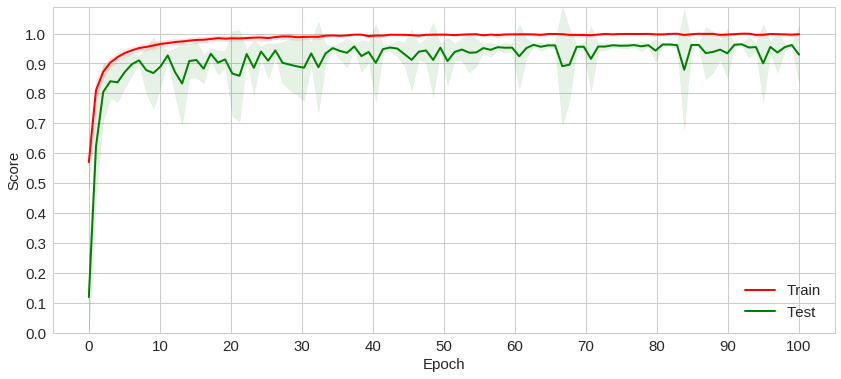

In [41]:
plot_mean_acc(hist)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

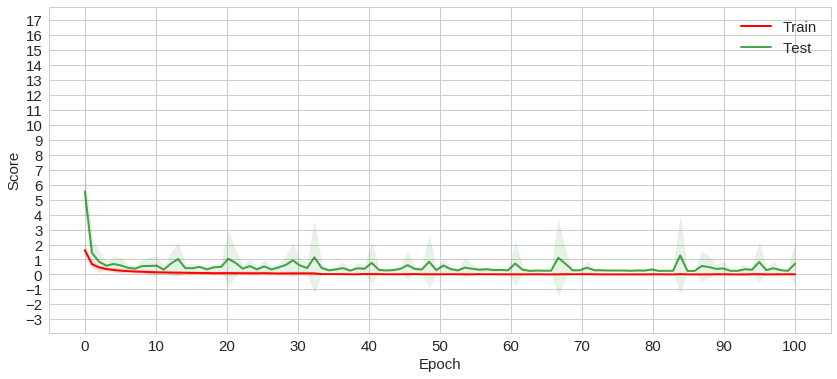

In [43]:
plot_mean_loss(hist)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

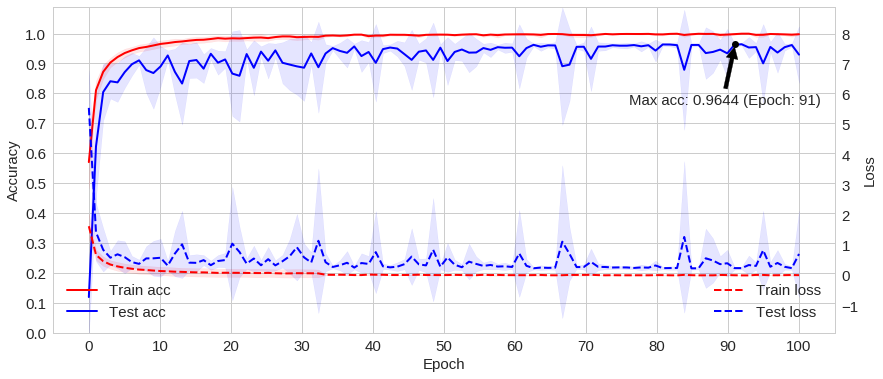

In [56]:
plot_mean(hist)